# FINM 33150 | Final Project Draft

Stephen Coley, Harrison Holt, Josh, Kyle Parran

Feb-24-2025

## The Task

The end goal here is to invent, simulate, and analyze a quantitative trading strategy.

Our initial ideas for a strategy include:


Once we determine a viable strategy we will need to ensure such a strategy has the following features:
- Investment in publicly traded (but not necessarily electronically traded) assets
- A "recipe" for evaluating attractiveness of potential trades that
    - depend on pre-specified classes of info
    - could be followed by anyone, given the recipe and data sources
- A "recipe" for investment sizes, and position entry and exit rules, that
    - may link position size to attractiveness
    - ensures risk stays within limits and capital remains bounded
    - makes reasonable assumptions about entry and exit liquidity

Elements of trading strategies include lead-lag relationships, market making, carry trades, pair trading, factor investment, model reversion, merger arbitrage, technical signals, etc.

Our strategy should have the following features:
- Significant dependence on at least one class of information that is not twitter, equity ohlc, equity VWAPs, or equity trading volumes, unelss at a relatively high frequency (600 secs or less)
- As of at least some times in your simulation, simultaneously holds at least 5 distinct assets (different currencies, commodities, option maturities/strikes etc.)
- Produces a total of 40 trades or more over your entire analysis/simulation period, without excessive clustering
- Leverage, with documented and reasonable capital and risk control assumptions


## Outline

### 1. Introduction

### 2. Data Assembly

### 3. Data Analysis

--------Next Phase--------

### 4. Strategy Implementation

### 6. Backtesting

### 7. Performance Analysis

### 8. References

## Introduction

## Setup

In [1]:
import pandas as pd
import numpy as np
import nasdaqdatalink as ndl
import quandl
import wrds
from dotenv import load_dotenv
import os
import datetime
from datetime import timedelta
from plotnine import ggplot, aes, geom_line, scale_color_manual, geom_hline, labs, theme, element_text, facet_wrap, geom_histogram, ggtitle, geom_boxplot, stat_function, geom_density
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
import functools
from scipy.stats import zscore
from sklearn.decomposition import PCA
from functools import lru_cache
import pytz
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

proj_dir = Path.cwd().parent
base_dir = proj_dir.parent
import sys
sys.path.append(str(proj_dir))
from helper.quandl_table import fetch_quandl_table, grab_quandl_table



warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

start_filter_date = '2018-01-01'
end_filter_date = '2024-12-31'

data_start_date = '2019-01-01'
data_end_date = '2024-12-31'

start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year
year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

# db = wrds.Connection(wrds_username=wrds_username, verbose = False)

## Data Assembly

### Data load

In [33]:
start_filter_date = '2018-01-01'
end_filter_date = '2024-12-31'

data_start_date = '2019-01-01'
data_end_date = '2024-12-31'

start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year
year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

**Zacks Fundamental B**

| Table                       | Table Code   | Table Description                                                                                                                                                                                                                                                                   |
|-----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fundamentals Condensed      | ZACKS/FC     | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.                                                                                                    |
| Fundamentals Ratios         | ZACKS/FR     | This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.                                                                                                                                                                           |
| Master Table                | ZACKS/MT     | This table contains descriptive information about all tickers that are included in Zacks products.                                                                                                                                                                                   |
| Market Value Supplement     | ZACKS/MKTV   | This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders. |
| Shares Out Supplement       | ZACKS/SHRS   | This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.                                              |
| Historical Daily Maintenance| ZACKS/HDM    | This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events. |

In [47]:

zacks_fc = fetch_quandl_table('ZACKS/FC', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_fr = fetch_quandl_table('ZACKS/FR', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_mt = fetch_quandl_table('ZACKS/MT', avoid_download=True)
zacks_mktv = fetch_quandl_table('ZACKS/MKTV', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_shrs = fetch_quandl_table('ZACKS/SHRS', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_hdm = fetch_quandl_table('ZACKS/HDM', avoid_download=True)

zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])+timedelta(days=1)
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_mktv['per_end_date'] = pd.to_datetime(zacks_mktv['per_end_date'])
zacks_shrs['per_end_date'] = pd.to_datetime(zacks_shrs['per_end_date'])
zacks_fc = zacks_fc.dropna(subset=['per_end_date', 'filing_date'])

zacks_data = pd.merge(zacks_fc, zacks_fr, on=['ticker', 'per_end_date', 'per_type'], how='left', suffixes=('_fc', '_fr'))
zacks_data = pd.merge(zacks_data, zacks_mktv, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_shrs, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_mt, on=['ticker'], how='left')

Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/FR
Skipping any possible download of ZACKS/MT
Skipping any possible download of ZACKS/MKTV
Skipping any possible download of ZACKS/SHRS
Skipping any possible download of ZACKS/HDM


In [48]:
# zacks_data.to_pickle('zacks_data.pkl')
zacks_data = pd.read_pickle('zacks_data.pkl')

In [49]:
top_stocks = zacks_mktv.loc[(zacks_mktv['per_end_date'] == zacks_mktv.per_end_date.max()) & (zacks_mktv['mkt_val']>=500)].sort_values(by='mkt_val', ascending=False).copy().reset_index(drop=True)
top_tickers = tuple(top_stocks.ticker)
top_tickers_list = list(top_tickers)

print(f"{len(top_tickers):,} tickers with market cap >= 500M")

3,196 tickers with market cap >= 500M


**Quandl EOD price data**

When referencing price end of day price data we will utilize Quandl End of Day US Stock Prices. Updated daily, this data feed offers end of day prices, dividends, adjustments and splits for U.S. publicly traded stocks with history to 1996. Prices are provided both adjusted and unadjusted.

Key Features:

- Covers all stocks with primary listing on NASDAQ, AMEX, NYSE and ARCA.
- Includes unadjusted and adjusted open, high, low, close, volume.
- Includes dividend history and split history.
- Updated at or before 5:00 pm ET on all trading days.
- Exchange corrections are applied by 9:30 pm ET.
- Historical data goes back to 1996.

In [50]:
eod_data = fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    avoid_download=True,
    ticker=top_tickers_list
)

spy_eod_data =  eod_data.loc[
                            (eod_data.ticker.isin(['SPY']))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

spy_eod_data = spy_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

spy_eod_data.to_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

top_eod_data = eod_data.loc[
                            (eod_data.ticker.isin(top_tickers_list))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

top_eod_data = top_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

top_eod_data.to_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

import gc
del eod_data
gc.collect()

spy_eod_data = pd.read_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')
top_eod_data = pd.read_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

spy_eod_data['daily_rets'] = spy_eod_data.groupby('ticker')['adj_close'].pct_change()
top_eod_data['daily_rets'] = top_eod_data.groupby('ticker')['adj_close'].pct_change()

display(top_eod_data.head())
display(top_eod_data.tail())
display(top_eod_data.describe())
display(top_eod_data.info())

Skipping any possible download of QUOTEMEDIA/PRICES


ticker        date   open   high     low  close     volume  dividend  split  \
0      A  2018-01-02  67.42  67.89  67.340  67.60  1047830.0       0.0    1.0   
1      A  2018-01-03  67.62  69.49  67.600  69.32  1698899.0       0.0    1.0   
2      A  2018-01-04  69.54  69.82  68.780  68.80  2231534.0       0.0    1.0   
3      A  2018-01-05  68.73  70.10  68.730  69.90  1632512.0       0.0    1.0   
4      A  2018-01-08  69.73  70.33  69.545  70.05  1613911.0       0.0    1.0   

    adj_open   adj_high    adj_low  adj_close  adj_volume  daily_rets  
0  64.141233  64.588376  64.065123  64.312479   1047830.0         NaN  
1  64.331506  66.110565  64.312479  65.948832   1698899.0    0.025444  
2  66.158133  66.424516  65.435093  65.454121   2231534.0   -0.007501  
3  65.387525  66.690899  65.387525  66.500625   1632512.0    0.015988  
4  66.338893  66.909714  66.162890  66.643331   1613911.0    0.002146

ticker        date   open     high     low  close    volume  dividend  \
4598159   ZYME  2024-12-24  14.30  14.3500  13.845  14.14  208994.0       0.0   
4598160   ZYME  2024-12-26  14.03  14.5100  13.800  14.50  263450.0       0.0   
4598161   ZYME  2024-12-27  14.52  14.5866  13.960  14.50  469356.0       0.0   
4598162   ZYME  2024-12-30  14.61  14.6800  13.771  14.51  360128.0       0.0   
4598163   ZYME  2024-12-31  14.62  14.8800  14.260  14.64  484379.0       0.0   

         split  adj_open  adj_high  adj_low  adj_close  adj_volume  daily_rets  
4598159    1.0     14.30   14.3500   13.845      14.14    208994.0   -0.009804  
4598160    1.0     14.03   14.5100   13.800      14.50    263450.0    0.025460  
4598161    1.0     14.52   14.5866   13.960      14.50    469356.0    0.000000  
4598162    1.0     14.61   14.6800   13.771      14.51    360128.0    0.000690  
4598163    1.0     14.62   14.8800   14.260      14.64    484379.0    0.008959

open          high           low         close        volume  \
count  4.598128e+06  4.598128e+06  4.598128e+06  4.598128e+06  4.598157e+06   
mean   7.405679e+01  7.509252e+01  7.300027e+01  7.405139e+01  2.104075e+06   
std    7.341813e+02  7.403105e+02  7.291132e+02  7.369912e+02  6.753616e+06   
min    5.000000e-02  5.000000e-02  5.000000e-02  5.000000e-02  0.000000e+00   
25%    1.589000e+01  1.618230e+01  1.559000e+01  1.588000e+01  2.121620e+05   
50%    3.589000e+01  3.647000e+01  3.529000e+01  3.588000e+01  6.084890e+05   
75%    7.693000e+01  7.796000e+01  7.586000e+01  7.692000e+01  1.695473e+06   
max    6.869938e+05  6.913435e+05  6.836920e+05  6.876000e+05  1.244189e+09   

           dividend         split      adj_open      adj_high       adj_low  \
count  4.598164e+06  4.598164e+06  4.598128e+06  4.598128e+06  4.598128e+06   
mean   3.722553e-03  1.000076e+00  6.709506e+01  6.804497e+01  6.612665e+01   
std    1.179002e-01  3.338524e-02  7.307159e+02  7.367900e+02  7.257134e+02   
min    0.000000e+00  2.000000e-02  9.010000e-02  1.222000e-01  8.620000e-02   
25%    0.000000e+00  1.000000e+00  1.470893e+01  1.498481e+01  1.442101e+01   
50%    0.000000e+00  1.000000e+00  3.267000e+01  3.320000e+01  3.212500e+01   
75%    0.000000e+00  1.000000e+00  7.013864e+01  7.114104e+01  6.910239e+01   
max    9.841142e+01  5.000000e+01  6.869938e+05  6.913435e+05  6.836920e+05   

          adj_close    adj_volume    daily_rets  
count  4.598128e+06  4.598157e+06  4.595118e+06  
mean   6.708862e+01  2.373206e+06  8.707380e-04  
std    7.335408e+02  1.225859e+07  1.735345e-01  
min    8.940000e-02  0.000000e+00 -9.220083e-01  
25%    1.470000e+01  2.115050e+05 -1.219741e-02  
50%    3.266000e+01  6.124480e+05  1.658787e-04  
75%    7.012050e+01  1.729571e+06  1.279527e-02  
max    6.876000e+05  2.511527e+09  3.408866e+02

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598164 entries, 0 to 4598163
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 526.2+ MB


None

##### Description of EOD Price Data

After applying our filter criteria, the dataset of EOD prices contains over 6.6M observations of EOD prices across multiple tickers.

Price Metrics (`adj_open`, `adj_high`, `adj_low`, `adj_close`)
- Mean Prices:
    - Open: $67.21
    - High: $68.10
    - Low: $66.30
    - Close: $67.21

Price Range:
- Minimum Price: $0.05
- Maximum Price: $9,924.40
- 25th Percentile: $16.37 (lower quartile)
- 50th Percentile (Median): $35.23
- 75th Percentile: $70.95

Price Volatility (Std):
- Standard deviation across prices: ~$166 (high variability, indicating a wide range of stock prices from penny stocks to large-cap stocks).


Trading Volume (`adj_volume`)
- Mean Trading Volume: ~1.99M shares per day
- Volume Range:
    - Minimum: 0 (some days had no trading activity)
    - Maximum: 1.24 billion shares
    - Median: 578,336 shares
    - 75th Percentile: 1.65M shares
- High standard deviation (~6.27M) indicates significant variation in trading volume across different stocks.

Keytakeways
- Highly Diverse Stock Universe: The dataset includes both small-cap and large-cap stocks, as evident from price extremes (from $0.05 to nearly $10,000).
- Significant Price Volatility: The high standard deviation across prices and returns suggests a mix of highly volatile and stable stocks.
- Extreme Trading Volumes: Some stocks trade billions of shares daily, while others have zero volume.

In [68]:
display(top_eod_data.describe())
print(top_eod_data.info())

print("\nSummary of Missing Values by Ticker")
display(top_eod_data.loc[top_eod_data.adj_close.isna()].groupby(['ticker']).size())

open          high           low         close        volume  \
count  4.598128e+06  4.598128e+06  4.598128e+06  4.598128e+06  4.598157e+06   
mean   7.405679e+01  7.509252e+01  7.300027e+01  7.405139e+01  2.104075e+06   
std    7.341813e+02  7.403105e+02  7.291132e+02  7.369912e+02  6.753616e+06   
min    5.000000e-02  5.000000e-02  5.000000e-02  5.000000e-02  0.000000e+00   
25%    1.589000e+01  1.618230e+01  1.559000e+01  1.588000e+01  2.121620e+05   
50%    3.589000e+01  3.647000e+01  3.529000e+01  3.588000e+01  6.084890e+05   
75%    7.693000e+01  7.796000e+01  7.586000e+01  7.692000e+01  1.695473e+06   
max    6.869938e+05  6.913435e+05  6.836920e+05  6.876000e+05  1.244189e+09   

           dividend         split      adj_open      adj_high       adj_low  \
count  4.598164e+06  4.598164e+06  4.598128e+06  4.598128e+06  4.598128e+06   
mean   3.722553e-03  1.000076e+00  6.709506e+01  6.804497e+01  6.612665e+01   
std    1.179002e-01  3.338524e-02  7.307159e+02  7.367900e+02  7.257134e+02   
min    0.000000e+00  2.000000e-02  9.010000e-02  1.222000e-01  8.620000e-02   
25%    0.000000e+00  1.000000e+00  1.470893e+01  1.498481e+01  1.442101e+01   
50%    0.000000e+00  1.000000e+00  3.267000e+01  3.320000e+01  3.212500e+01   
75%    0.000000e+00  1.000000e+00  7.013864e+01  7.114104e+01  6.910239e+01   
max    9.841142e+01  5.000000e+01  6.869938e+05  6.913435e+05  6.836920e+05   

          adj_close    adj_volume    daily_rets  
count  4.598128e+06  4.598157e+06  4.595118e+06  
mean   6.708862e+01  2.373206e+06  8.707380e-04  
std    7.335408e+02  1.225859e+07  1.735345e-01  
min    8.940000e-02  0.000000e+00 -9.220083e-01  
25%    1.470000e+01  2.115050e+05 -1.219741e-02  
50%    3.266000e+01  6.124480e+05  1.658787e-04  
75%    7.012050e+01  1.729571e+06  1.279527e-02  
max    6.876000e+05  2.511527e+09  3.408866e+02

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598164 entries, 0 to 4598163
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 526.2+ MB
None

Summary of Missing Values by Ticker


ticker
AACT     1
BIO.B    5
FORTY    5
FWONB    1
HDL      1
LBTYB    3
LVRO     1
MOG.B    4
SIM      1
SMSMY    1
SPLP     1
SVA      5
WLYB     2
WSO.B    5
dtype: int64

Below we analyze the distribution of the daily returns for each ticker to identify any data irregularities.

- Leptokurtic Distribution: The actual distribution has a much sharper peak and fatter tails than a normal distribution, indicating high kurtosis.
- Stock Market Returns are Not Normal: This confirms well-known financial market behavior—returns tend to have fatter tails and more frequent extreme movements (eg large crashes or spikes).
- Risk Implications:
    - Traditional models assuming normality may underestimate risk due to tail risk.
    - Risk management strategies should account for these higher probabilities of extreme losses/gains.

In [64]:
def plot_p9_pdf(data):
    column_name = data.columns[0]
    mean = data.mean().iloc[0]
    std = data.std().iloc[0]

    pdf_plot = (
        ggplot(data, aes(x=column_name)) +
        geom_density(color='red', fill='red', alpha=0.5) +
        stat_function(
            fun=norm.pdf,
            args=(mean, std),
            color='blue',
            size=1
        ) +
        ggtitle(f'PDF of {column_name} compared to normal distribution') +
        theme(figure_size=(7, 5))
    )

    print(pdf_plot)

daily_rets = spy_eod_data['daily_rets']
# daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)


daily_rets = top_eod_data['daily_rets']
daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)

ValueError: Data must be 1-dimensional, got ndarray of shape (0, 1) instead

**WRDS Market Data Bars (WRDS TAQ)**

WRDS TAQ has millisecond-level best bid and offer data.  However, downloading the full data series is not practical due to the hundreds of millions of rows per day.  Here, we use SQL to generate more manageable "bars" on the server side.

In [6]:
# @lru_cache
# def taq_nbbo_bars_on_date(tickers: list[str] | str, date:datetime.date, bar_minutes=30):
#     assert bar_minutes==60 or (bar_minutes<=30 and 30%bar_minutes==0)
#     date_str = date.strftime('%Y%m%d')
#     year_str = date.strftime('%Y')
#     tickers = (tickers,) if hasattr(tickers,'strip') else tuple(tickers)  # Allow single ticker as argument

#     sql = f"""
#             WITH windowable_nbbo AS (
#                 SELECT
#                     sym_root AS ticker
#                     , date
#                     , time_m
#                     , time_m_nano
#                     , sym_root
#                     , qu_cond
#                     , best_bid
#                     , best_bidsizeshares
#                     , best_ask
#                     , best_asksizeshares
#                     , EXTRACT(HOUR FROM time_m) AS hour_of_day
#                     , {bar_minutes} * DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) AS minute_of_hour
#                     , ROW_NUMBER() OVER (PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) ORDER BY time_m DESC) AS rownum
#                 FROM taqm_{year_str}.complete_nbbo_{date_str} 
#                 WHERE 1=1
#                   AND sym_root IN {tickers}
#                   AND sym_suffix IS NULL
#                   AND time_m > '09:30:00' AND time_m < '16:00:00'
#             )
#             SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
#                 ticker
#                 , date
#                 , date + (hour_of_day || ':' || minute_of_hour)::interval + ( '00:{bar_minutes}' )::interval AS window_time
#                 , best_bid
#                 , best_bidsizeshares
#                 , best_ask
#                 , best_asksizeshares
#                 , time_m AS time_of_last_quote
#                 , time_m_nano AS time_of_last_quote_ns
#             FROM windowable_nbbo
#             WHERE windowable_nbbo.rownum = 1
#             """
#     bars = db.raw_sql(sql)
    
#     def _make_timestamp(r):
#         t = datetime.datetime.combine(r.date, r.time_of_last_quote)#, tzinfo=pytz.timezone('America/New_York'))
#         pdt = pd.to_datetime(t).tz_localize(pytz.timezone('America/New_York')) + pd.Timedelta(r.time_of_last_quote_ns, unit="ns")
#         return pdt
#     bars['time_of_last_quote'] = bars.apply(_make_timestamp, axis=1)
#     del bars['time_of_last_quote_ns']
#     bars['window_time'] = pd.to_datetime(bars['window_time']).dt.tz_localize(pytz.timezone('America/New_York'))
#     return bars

#### **WRDS I/B/E/S Summary History**

​Refinitiv's Institutional Brokers' Estimate System (I/B/E/S) offers a comprehensive database of analyst forecasts and actual earnings data for publicly traded companies worldwide. The "Surprise History" within I/B/E/S specifically focuses on earnings surprises, providing insights into how actual earnings compare to analyst expectations over time.

Key components of the I/B/E/S Surprise History data include:
- Analyst Estimates: Forecasts for various financial metrics, notably Earnings Per Share (EPS), collected from a vast network of analysts. These estimates are aggregated to form consensus figures, serving as benchmarks for actual performance.​
- Actual Reported Earnings: The realized financial figures reported by companies, allowing for direct comparison against prior analyst projections.​


In [101]:
# query_ibes = """
#     SELECT 
#         *  
#     FROM 
#         tr_ibes.surpsum
#     LIMIT 10000
# """
# surpsum = db.raw_sql(query_ibes)
surp_sum = pd.read_parquet(proj_dir/"data/surpsum.parquet")


display(surp_sum.head())
display(surp_sum.tail())
display(surp_sum.describe())

# surp_sum.head()

ticker oftic measure fiscalp   pyear  pmon  usfirm     anndats  actual  \
0   0000  TLMR     EPS     QTR  2014.0   3.0       1  2014-05-06    0.12   
1   0000  TLMR     EPS     QTR  2014.0   6.0       1  2014-08-06    0.27   
2   0000  TLMR     EPS     QTR  2014.0   9.0       1  2014-11-04    0.26   
3   0000  TLMR     EPS     QTR  2014.0  12.0       1  2015-01-30    0.16   
4   0000  TLMR     EPS     QTR  2015.0   3.0       1  2015-04-30    0.12   

   surpmean  surpstdev  suescore  
0   0.08000    0.01414   2.82845  
1   0.13000    0.01225  11.43137  
2   0.23200    0.05848   0.47879  
3   0.17167    0.01169  -0.99800  
4   0.17833    0.01835  -3.17927

ticker oftic measure fiscalp   pyear  pmon  usfirm     anndats  actual  \
184260   ZYNX  ZYXI     EPS     QTR  2023.0   9.0       1  2023-10-26    0.10   
184261   ZYNX  ZYXI     EPS     QTR  2023.0  12.0       1  2024-02-29    0.21   
184262   ZYNX  ZYXI     EPS     QTR  2024.0   3.0       1  2024-04-30    0.00   
184263   ZYNX  ZYXI     EPS     QTR  2024.0   6.0       1  2024-07-25    0.04   
184264   ZYNX  ZYXI     EPS     QTR  2024.0   9.0       1  2024-10-24    0.07   

        surpmean  surpstdev  suescore  
184260   0.09333    0.00577   1.15460  
184261   0.17000    0.00000       NaN  
184262   0.03333    0.00577  -5.77300  
184263   0.07667    0.00577  -6.35031  
184264   0.05667    0.01155   1.15470

pyear           pmon    usfirm        actual      surpmean  \
count  184265.000000  184265.000000  184265.0  1.829240e+05  1.842650e+05   
mean     2018.988631       7.277378       1.0 -2.590439e+05 -6.934898e+05   
std         3.118206       3.349609       0.0  5.755641e+07  1.944187e+08   
min      2014.000000       1.000000       1.0 -1.915200e+10 -6.048000e+10   
25%      2016.000000       3.000000       1.0 -1.000000e-01 -9.000000e-02   
50%      2019.000000       6.000000       1.0  2.400000e-01  2.133300e-01   
75%      2022.000000       9.000000       1.0  7.200000e-01  6.600000e-01   
max      2024.000000      12.000000       1.0  2.475000e+05  2.100000e+05   

          surpstdev       suescore  
count  1.585630e+05  154849.000000  
mean   6.702800e+03       1.125547  
std    1.406790e+06      68.310700  
min    0.000000e+00   -3475.463160  
25%    1.680000e-02      -0.707110  
50%    3.830000e-02       0.676570  
75%    9.732000e-02       2.407200  
max    4.725256e+08   25909.274190

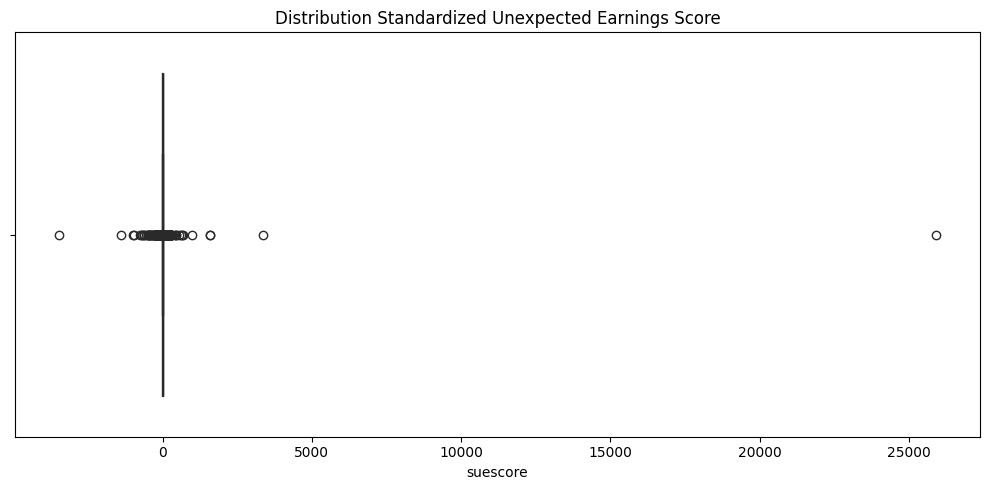

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

**Fama-French Factor Returns**

We obtained the Fama-French factor returns (SMB, HML, RF and Mkt-RF) over the same data period as trading period (reference https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [73]:
ff_file_path = proj_dir/f"data/F-F_Research_Data_Factors_daily.csv"
ff_data = pd.read_csv(ff_file_path)
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')
display(ff_data.head())
display(ff_data.tail())

date  Mkt-RF   SMB   HML     RF
0 1926-07-01    0.10 -0.25 -0.27  0.009
1 1926-07-02    0.45 -0.33 -0.06  0.009
2 1926-07-06    0.17  0.30 -0.39  0.009
3 1926-07-07    0.09 -0.58  0.02  0.009
4 1926-07-08    0.21 -0.38  0.19  0.009

date  Mkt-RF   SMB   HML    RF
25875 2024-11-22    0.54  1.25  0.41  0.02
25876 2024-11-25    0.40  1.07  0.27  0.02
25877 2024-11-26    0.42 -0.92 -0.71  0.02
25878 2024-11-27   -0.39  0.28  0.47  0.02
25879 2024-11-29    0.54  0.14 -0.64  0.02

### Data Cleansing/Merge

#### Earnings Surprise Data
Below we are: 
- Converting "anndats" to a proper datetime, dropping any rows where it’s missing.
- Extracting the year from each announcement date, which we will use as a proxy for determining which data is consistent throughout.
- Filtering to keep only tickers that appear in every year of our date range   (year_beginning_filter through year_end_filter).
- Further ensuring each ticker has 4 quarters of data each year for consistently quarterly coverage.
- Removing any ticker that fails these conditions, leaving a final set of tickers meeting both the year coverage and 4-quarter criteria.
- Printing out the number of Investable universe of stocks for this dataset

In [102]:
# Cleaning the surprise Data
surp_sum['anndats'] = pd.to_datetime(surp_sum['anndats'], errors='coerce')
surp_sum = surp_sum[surp_sum['anndats'].notnull()]

surp_sum['year'] = surp_sum['anndats'].dt.year

years_required = set(range(year_beginning_filter, year_end_filter+1))

coverage = surp_sum.groupby('oftic')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda x: years_required.issubset(x))].index
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers)]

quarter_counts = (
    surp_sum
    .groupby(['oftic', 'year'])
    .size()
    .reset_index(name='count_per_year')
)

quarter_counts_ok = quarter_counts[quarter_counts['count_per_year'] >= 4]

annual_coverage = quarter_counts_ok.groupby('oftic')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda x: years_required.issubset(x))].index

# Filtering out stocks that dont have 4 quarters of data for each year
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers_4q)]
surp_sum.drop(['ticker'], axis=1, inplace=True)
surp_sum['oftic'].nunique()

1747

##### Integrating Zack's Fundamental B Dataset
Below we are:
- Setting a market value threshold of $500 million to ensure our data stays above that amount throughout the entire date range.
- Calculating new metrics for use in rankings, P/E, EV/EBITDA, and YoY growth in revenue and price
- Ensuring we have consistent quarterly data for all the metrics below
- Printing out the unique amount of filters that pass these filters.
- We then filter the remaining tickers on what we have in the filtered surprise dataset to end up with 327 individual stocks that pass our criteria

In [103]:
zacks_cols = [
    'ticker',
    'per_end_date',
    'per_type',
    'tot_revnu',
    'eps_diluted_net',
    'basic_net_eps',
    'tot_lterm_debt',
    'net_lterm_debt',
    'net_curr_debt',
    'tot_debt_tot_equity',
    'ret_invst',
    'free_cash_flow_per_share',
    'ebitda',
    'shares_out',
    'mkt_val'
]

# Setting The Market Cap Threshold to Filter out Smaller Companies
mkt_cap_threshold = 500

# Selecting the metrics we plan to include in our strategy
zacks_df = zacks_data.loc[zacks_data.ticker.isin(top_tickers_list)].copy()
zacks_df = zacks_df[zacks_df['per_end_date'].notnull() & (zacks_df['per_type'] == 'Q')]
zacks_df.dropna(subset=zacks_cols, inplace=True)
zacks_df.sort_values(['ticker','per_end_date'], inplace=True)

zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filing_date, end_filing_date)]

# Filtering Stocks to a smaller date range
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filter_date, end_filter_date)]
zacks_df['year'] = zacks_df['per_end_date'].dt.year


years_required = set(range(year_beginning_filter, year_end_filter + 1))
coverage = zacks_df.groupby('ticker')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers)]

zacks_df['ticker'].nunique()

268

In [104]:
# Filtering the surprise data on market cap requirement
valid_tickers = set(zacks_df['ticker'].unique())
surp_sum_filtered = surp_sum[surp_sum['oftic'].isin(valid_tickers)].reset_index(drop=True)

surp_sum_filtered['oftic'].nunique()

195

##### Transforming the primary final dataset
Below we are:
- Assign tickers to bins based on their avg_EPS to ensure we are comparing similar magnitudes of percent changes.
- We then transform the daily stock data obtained from the 'QUOTEMEDIA/PRICES' dataset to obtain the next day adjusted close and compute the return between those two days to capture the initial movement of the earnings surprise
- We merge these two datasets and bring in the relevant columns.
- The avg_eps_estimate is then calculated from subtracting the surprise mean from the actual EPS.
- Pct_surprise is calculated as the (average surprise)/ (the next day return)
- We then calculate the primary metric 'surprise_vs_move' which is simply the pct_surprise/(next day return). This should help us gauge how much the stock moved relative to it's surprise number
- The data is then translated into a z-score subtracting the mean of the bin it is in as well as dividing by the standard deviation of the same bin.

In [105]:
# # Separating the Surprises into Bins
# surp_sum_filtered['avg_eps'] = surp_sum_filtered.groupby('ticker')['actual'].transform('mean')
# bins = [-np.inf, 0, 0.5, 1, 2,  np.inf]
# labels = [
#     "Negative",
#     "0 to 0.5",
#     "0.5 to 1.0",
#     "1.0 to 2.0",
#     ">2.0"
# ]

# surp_sum_filtered['avg_eps_bin'] = pd.cut(surp_sum_filtered['avg_eps'], bins=bins, labels=labels)


# surp_sum_filtered.groupby('avg_eps_bin')['ticker'].nunique()

In [106]:
# Sorting close prices for merge
eod_data = top_eod_data.loc[top_eod_data.ticker.isin(surp_sum_filtered['oftic'].unique())].copy().reset_index(drop=True)

eod_data['date'] = pd.to_datetime(eod_data['date'])
surp_sum_filtered['anndats'] = pd.to_datetime(surp_sum_filtered['anndats'])

# Merging the surprise data with the EOD data
eod_surp_merged = pd.merge(
    eod_data[['ticker','date','adj_close']],
    surp_sum_filtered,
    how='left',
    left_on=['ticker','date'],
    right_on=['oftic','anndats']    
)

eod_surp_merged = eod_surp_merged.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [107]:
display(eod_surp_merged.head())
display(eod_surp_merged.tail())

ticker       date  adj_close oftic measure fiscalp  pyear  pmon  usfirm  \
0   AAOI 2018-01-02      37.91   NaN     NaN     NaN    NaN   NaN     NaN   
1   AAOI 2018-01-03      37.89   NaN     NaN     NaN    NaN   NaN     NaN   
2   AAOI 2018-01-04      38.38   NaN     NaN     NaN    NaN   NaN     NaN   
3   AAOI 2018-01-05      38.89   NaN     NaN     NaN    NaN   NaN     NaN   
4   AAOI 2018-01-08      38.37   NaN     NaN     NaN    NaN   NaN     NaN   

  anndats  actual  surpmean  surpstdev  suescore  year  
0     NaT     NaN       NaN        NaN       NaN   NaN  
1     NaT     NaN       NaN        NaN       NaN   NaN  
2     NaT     NaN       NaN        NaN       NaN   NaN  
3     NaT     NaN       NaN        NaN       NaN   NaN  
4     NaT     NaN       NaN        NaN       NaN   NaN

ticker       date  adj_close oftic measure fiscalp   pyear  pmon  \
341634     ZG 2024-12-24      73.80    ZG     EPS     QTR  2024.0   9.0   
341635     ZG 2024-12-26      73.66    ZG     EPS     QTR  2024.0   9.0   
341636     ZG 2024-12-27      72.74    ZG     EPS     QTR  2024.0   9.0   
341637     ZG 2024-12-30      71.30    ZG     EPS     QTR  2024.0   9.0   
341638     ZG 2024-12-31      70.85    ZG     EPS     QTR  2024.0   9.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  
341634     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0  
341635     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0  
341636     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0  
341637     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0  
341638     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0

##### Merging the Fundamentals and Surprise Data
Below we are:
- Transforming the fundamental data and Earnings Surprise to ensure that we have a latest date for both to avoid lookahead bias in trades. To be safe we assume we are only available to trade on this information after the announcement and filing date.
- Both of the datasets are then merged on 'ticker' and 'oftic'.
- Trade day is then calculated as the latest day between the two announcements
- Calculate Z_scores for new metrics within bins
- We then drop incomplete rows and features for a final cleanup.

In [108]:
zacks_df['valid_from'] = zacks_df['filing_date'] + pd.Timedelta(days=1)

fund_data = zacks_df[zacks_cols+['valid_from']].copy()

surp_data = eod_surp_merged.copy()

surp_data_sorted = surp_data.sort_values(by="date")
fund_data_sorted = fund_data.sort_values(by="valid_from")

merged_df = pd.merge(
    surp_data_sorted,
    fund_data_sorted,
    how='left',
    left_on=['ticker','date'],
    right_on=['ticker','valid_from']    
)

merged_df = merged_df.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [109]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341640 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    341640 non-null  object        
 1   date                      341640 non-null  datetime64[ns]
 2   adj_close                 341640 non-null  float64       
 3   oftic                     336270 non-null  object        
 4   measure                   336270 non-null  object        
 5   fiscalp                   336270 non-null  object        
 6   pyear                     336270 non-null  float64       
 7   pmon                      336270 non-null  float64       
 8   usfirm                    336270 non-null  float64       
 9   anndats                   336270 non-null  datetime64[ns]
 10  actual                    336270 non-null  float64       
 11  surpmean                  336270 non-null  float64       
 12  su

In [110]:
# Identifying tickers that have missing rev_yoy_growth or price_yoy_growth
tickers_with_na = (
    merged_df
    .loc[(merged_df.isna().any(axis=1)) & (merged_df.date>=data_start_date) & (merged_df.date<=data_end_date), 'ticker']
    .unique()
)

# # Dropping all rows belonging to these tickers
merged_df = merged_df[~merged_df['ticker'].isin(tickers_with_na)]

In [111]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227169 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    227169 non-null  object        
 1   date                      227169 non-null  datetime64[ns]
 2   adj_close                 227169 non-null  float64       
 3   oftic                     223521 non-null  object        
 4   measure                   223521 non-null  object        
 5   fiscalp                   223521 non-null  object        
 6   pyear                     223521 non-null  float64       
 7   pmon                      223521 non-null  float64       
 8   usfirm                    223521 non-null  float64       
 9   anndats                   223521 non-null  datetime64[ns]
 10  actual                    223521 non-null  float64       
 11  surpmean                  223521 non-null  float64       
 12  surpstd

In [112]:
display(merged_df.describe())
display(merged_df.info())

date      adj_close          pyear  \
count                         227169  227169.000000  223521.000000   
mean   2021-07-01 15:36:17.172061440      83.290064    2020.731918   
min              2018-01-02 00:00:00       1.040000    2017.000000   
25%              2019-10-02 00:00:00      30.532143    2019.000000   
50%              2021-07-01 00:00:00      56.750697    2021.000000   
75%              2023-03-31 00:00:00     108.508164    2022.000000   
max              2024-12-31 00:00:00     958.350400    2024.000000   
std                              NaN      83.934252       2.015584   

                pmon    usfirm                        anndats         actual  \
count  223521.000000  223521.0                         223521  223521.000000   
mean        7.364248       1.0  2021-06-06 21:53:41.093320704       1.170675   
min         3.000000       1.0            2018-01-18 00:00:00     -10.440000   
25%         3.000000       1.0            2019-10-16 00:00:00       0.430000   
50%         6.000000       1.0            2021-05-10 00:00:00       0.850000   
75%         9.000000       1.0            2023-02-21 00:00:00       1.560000   
max        12.000000       1.0            2024-11-14 00:00:00      17.180000   
std         3.279961       0.0                            NaN       1.435480   

            surpmean      surpstdev       suescore           year  \
count  223521.000000  223521.000000  223521.000000  223521.000000   
mean        1.090781       0.088005       1.476965    2020.952282   
min       -10.521400       0.000000     -94.046100    2018.000000   
25%         0.396000       0.024630      -0.111980    2019.000000   
50%         0.786440       0.046210       1.079940    2021.000000   
75%         1.467500       0.097460       2.821350    2023.000000   
max        12.894400       3.795910      42.899650    2024.000000   
std         1.290044       0.162817       4.560138       1.977989   

                        per_end_date      tot_revnu  eps_diluted_net  \
count                         212061  212061.000000    212061.000000   
mean   2021-02-10 20:09:38.754226432    4232.198067         0.694976   
min              2018-03-31 00:00:00    -357.000000       -20.960000   
25%              2019-06-30 00:00:00     682.405000         0.210000   
50%              2020-09-30 00:00:00    1596.000000         0.690000   
75%              2022-09-30 00:00:00    4151.000000         1.300000   
max              2024-09-30 00:00:00   91819.000000        16.280000   
std                              NaN    8614.624929         2.203923   

       basic_net_eps  tot_lterm_debt  net_lterm_debt  net_curr_debt  \
count  212061.000000   212061.000000   212061.000000  212061.000000   
mean        0.700009     9397.066335      368.719323     103.316249   
min       -20.960000        0.021000   -17199.000000  -22642.000000   
25%         0.220000     1295.300000      -44.500000    -100.000000   
50%         0.700000     3513.530000        0.550000       0.640000   
75%         1.310000    10299.000000      511.000000     143.000000   
max        16.280000   105752.000000    27380.000000   48256.900000   
std         2.225439    15372.010323     2044.447160    2390.219938   

       tot_debt_tot_equity      ret_invst  free_cash_flow_per_share  \
count        212061.000000  212061.000000             212061.000000   
mean              2.126706       1.785325                  1.687783   
min            -611.650000     -29.669200                -34.148800   
25%               0.584900       0.568100                 -0.552700   
50%               1.125300       1.628400                  0.984100   
75%               1.897600       3.107200                  3.201000   
max             459.480300      37.681200                 92.216200   
std              18.732826       5.284895                  6.201952   

              ebitda     shares_out       mkt_val  \
count  212061.000000  212061.000000  2.120610e+05   
mean      864.992884   

<class 'pandas.core.frame.DataFrame'>
Index: 227169 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    227169 non-null  object        
 1   date                      227169 non-null  datetime64[ns]
 2   adj_close                 227169 non-null  float64       
 3   oftic                     223521 non-null  object        
 4   measure                   223521 non-null  object        
 5   fiscalp                   223521 non-null  object        
 6   pyear                     223521 non-null  float64       
 7   pmon                      223521 non-null  float64       
 8   usfirm                    223521 non-null  float64       
 9   anndats                   223521 non-null  datetime64[ns]
 10  actual                    223521 non-null  float64       
 11  surpmean                  223521 non-null  float64       
 12  surpstd

None

In [113]:
merged_df.to_parquet('../data/merged_data.parquet')
merged_df = pd.read_parquet('../data/merged_data.parquet')

## **Feature Engineering**

To capture disposition effect and underreaction to news, we will constrcut factors incorporating fundamental, earnings, and price data.

1. Disposition Effect Signals
- Capital Gains Overhang:
    - Compute unrealized capital gains/losses using mutual fund holdings (due to limited data we are using a reference price instaed) and stock price history.
    - $CGO = (Current Price - Weighted Average Purchase Price) / Current Price$
    - Stocks with large unrealized losses tend to underreact to bad news.
- Realized vs. Unrealized Gains Ratio:
    - High values: Investors aggressively taking profits (possible reversal).
    - Low values: Investors reluctant to realize losses (potential underreaction).

2. PEAD Signals
- Earnings Surprise (SUE - Standardized Unexpected Earnings):
    - $SUE = (Actual\ EPS - Expected\ EPS) / Std\ of\ EPS\ Estimates$
    - Higher SUE: Stronger PEAD effects
- Earnings Drift Factor:
    - Stocks with high past earnings surprise but low short-term reaction may exhibit PEAD.
    - Compute cumulative abnormal returns (CAR) post-earnings
        - We will test different window lengths (5-day, 30-day, etc)

3. Momentum & Technical Signals
- N-Month Momentum: Stocks with strong past N-month returns tend to continue moving in the same direction.
- Relative Strength Index: Captures overbought/oversold condition
    - We will test different windows here
- Short-Term Reversals: Compute N-week return to detect extreme short-term movements

4. Fundamentals


\begin{array}{|l|l|l|}
\hline
\textbf{Feature Name} & \textbf{Definition} & \textbf{Purpose} \\
\hline
ps\ ratio & \text{Market Value / Total Revenue} & \text{Valuation} \\
earnings\ yield & \text{EPS / Market Value per Share} & \text{Valuation} \\
fcf\ yield & \text{Free Cash Flow per Share / Market Value per Share} & \text{Valuation} \\
ebitda\ margin & \text{EBITDA / Total Revenue} & \text{Profitability} \\
roi\ scaled & \text{Return on Investment} & \text{Profitability} \\
eps\ growth & \text{YoY EPS Growth} & \text{Growth} \\
debt\ to\ equity & \text{Total Debt / Total Equity} & \text{Leverage} \\
net\ debt\ to\ ebitda & \text{(Net LT Debt + Net Current Debt) / EBITDA} & \text{Leverage} \\
debt\ to\ revenue & \text{Total LT Debt / Total Revenue} & \text{Leverage} \\
revenue\ growth & \text{YoY Revenue Growth} & \text{Growth} \\
ebitda\ growth & \text{YoY EBITDA Growth} & \text{Growth} \\
mkt\ cap\ growth & \text{YoY Market Cap Growth} & \text{Growth} \\
log\ mkt\ cap & \text{Log of Market Cap} & \text{Size Indicator} \\
fcf\ growth & \text{YoY Free Cash Flow Growth} & \text{Growth} \\
\hline
\end{array}

### add open and volume columns

In [52]:
top_eod_data.head()

ticker        date   open   high     low  close     volume  dividend  split  \
0      A  2018-01-02  67.42  67.89  67.340  67.60  1047830.0       0.0    1.0   
1      A  2018-01-03  67.62  69.49  67.600  69.32  1698899.0       0.0    1.0   
2      A  2018-01-04  69.54  69.82  68.780  68.80  2231534.0       0.0    1.0   
3      A  2018-01-05  68.73  70.10  68.730  69.90  1632512.0       0.0    1.0   
4      A  2018-01-08  69.73  70.33  69.545  70.05  1613911.0       0.0    1.0   

    adj_open   adj_high    adj_low  adj_close  adj_volume  daily_rets  
0  64.141233  64.588376  64.065123  64.312479   1047830.0         NaN  
1  64.331506  66.110565  64.312479  65.948832   1698899.0    0.025444  
2  66.158133  66.424516  65.435093  65.454121   2231534.0   -0.007501  
3  65.387525  66.690899  65.387525  66.500625   1632512.0    0.015988  
4  66.338893  66.909714  66.162890  66.643331   1613911.0    0.002146

In [68]:
top_eod_data['date'] = pd.to_datetime(top_eod_data['date'])
merged_df = pd.read_parquet('../data/merged_data_official.parquet')
merged_df_2 = pd.merge(merged_df, top_eod_data[['ticker', 'date', 'adj_open', 'adj_volume']], how='left', on=['ticker', 'date'])
merged_df_2.tail()

ticker       date  adj_close oftic measure fiscalp   pyear  pmon  \
230788    CAT 2024-12-31     362.76   CAT     EPS     QTR  2024.0   9.0   
230789   SBUX 2024-12-31      91.25  SBUX     EPS     QTR  2024.0   9.0   
230790    CCI 2024-12-31      90.76   CCI     EPS     QTR  2024.0   9.0   
230791    CCK 2024-12-31      82.69   CCK     EPS     QTR  2024.0   9.0   
230792     ZG 2024-12-31      70.85    ZG     EPS     QTR  2024.0   9.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
230788     1.0 2024-10-30    5.17   5.33672    0.16314  -1.02195  2024.0   
230789     1.0 2024-10-30    0.80   1.02804    0.03286  -6.94071  2024.0   
230790     1.0 2024-10-16    0.70   0.66592    0.05014   0.67962  2024.0   
230791     1.0 2024-10-17    1.99   1.80107    0.02131   8.86614  2024.0   
230792     1.0 2024-11-06    0.35   0.29238    0.02318   2.48567  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
230788   2024-09-30        Q  16106.000             5.06           5.09   
230789   2024-09-30        Q   9073.999             0.80           0.80   
230790   2024-09-30        Q   1652.000             0.70           0.70   
230791   2024-06-30        Q   3040.000             1.45           1.45   
230792   2024-09-30        Q    581.000            -0.08          -0.08   

        tot_lterm_debt  net_lterm_debt  net_curr_debt  tot_debt_tot_equity  \
230788         25784.0        717.0000         -848.0               1.9534   
230789         14319.5        170.2001          -33.7              -2.0921   
230790         23452.0        423.0000          642.0               4.5436   
230791          5949.0        -40.0000           80.0               2.4891   
230792           497.0       -697.0000           55.0               0.2283   

        ret_invst  free_cash_flow_per_share    ebitda  shares_out    mkt_val  \
230788     5.4507                   14.3929  4026.000      482.80  188833.70   
230789    13.2264                    2.9175  1708.401     1133.20  110475.66   
230790     1.0540                    2.5688   982.000      434.60   51556.38   
230791     2.3191                    1.5609   494.000      120.64    8974.45   
230792    -0.3881                    0.8472    26.000      233.56   14464.32   

       valid_from  adj_open  adj_volume  
230788 2024-11-08    363.50   1168071.0  
230789 2024-11-22     90.73   4220716.0  
230790 2024-11-01     90.00   3087257.0  
230791 2024-07-31     82.15    540136.0  
230792 2024-11-08     71.72    351194.0

In [69]:
merged_df_2.to_parquet('../data/merged_data_official_2.parquet')

### Run with new data

In [2]:
merged_df = pd.read_parquet('../data/merged_data_official_2.parquet')
merged_df.head()

ticker       date   adj_close oftic measure fiscalp  pyear  pmon  usfirm  \
0   AAOI 2018-01-02   37.910000  None    None    None    NaN   NaN     NaN   
1    SCI 2018-01-02   33.605937  None    None    None    NaN   NaN     NaN   
2    CCI 2018-01-02   81.755975  None    None    None    NaN   NaN     NaN   
3    CAT 2018-01-02  133.901045  None    None    None    NaN   NaN     NaN   
4   CACI 2018-01-02  134.150000  None    None    None    NaN   NaN     NaN   

  anndats  actual  surpmean  surpstdev  suescore  year per_end_date per_type  \
0     NaT     NaN       NaN        NaN       NaN   NaN          NaT     None   
1     NaT     NaN       NaN        NaN       NaN   NaN          NaT     None   
2     NaT     NaN       NaN        NaN       NaN   NaN          NaT     None   
3     NaT     NaN       NaN        NaN       NaN   NaN          NaT     None   
4     NaT     NaN       NaN        NaN       NaN   NaN          NaT     None   

   tot_revnu  eps_diluted_net  basic_net_eps  tot_lterm_debt  net_lterm_debt  \
0        NaN              NaN            NaN             NaN             NaN   
1        NaN              NaN            NaN             NaN             NaN   
2        NaN              NaN            NaN             NaN             NaN   
3        NaN              NaN            NaN             NaN             NaN   
4        NaN              NaN            NaN             NaN             NaN   

   net_curr_debt  tot_debt_tot_equity  ret_invst  free_cash_flow_per_share  \
0            NaN                  NaN        NaN                       NaN   
1            NaN                  NaN        NaN                       NaN   
2            NaN                  NaN        NaN                       NaN   
3            NaN                  NaN        NaN                       NaN   
4            NaN                  NaN        NaN                       NaN   

   ebitda  shares_out  mkt_val valid_from    adj_open  adj_volume  
0     NaN         NaN      NaN        NaT   37.800000    964609.0  
1     NaN         NaN      NaN        NaT   33.418791   1655997.0  
2     NaN         NaN      NaN        NaT   82.956834   2036131.0  
3     NaN         NaN      NaN        NaT  134.975391   5108362.0  
4     NaN         NaN      NaN        NaT  133.450000    134433.0

In [3]:
merged_df['days_since_announcement'] = (merged_df['date'] - merged_df['anndats']).dt.days
merged_df['close_after_announcement'] = merged_df.groupby('ticker')['adj_close'].shift(-1)
merged_df['close_after_announcement'] = merged_df['close_after_announcement'].where(merged_df['days_since_announcement'] == 0, np.nan)
merged_df['close_after_announcement'] = merged_df['close_after_announcement'].groupby(merged_df['ticker']).shift(1)
merged_df['close_after_announcement'] = merged_df['close_after_announcement'].groupby(merged_df['ticker']).ffill()
merged_df['return_since_announcement'] = (merged_df['adj_close'] - merged_df['close_after_announcement']) / merged_df['close_after_announcement']
merged_df[(merged_df['ticker']=='AAPL') & (merged_df['date']>='2024-10-30') & (merged_df['date']<'2024-11-05')]

ticker       date   adj_close oftic measure fiscalp   pyear  pmon  \
225271   AAPL 2024-10-30  229.846820  AAPL     EPS     QTR  2024.0   6.0   
225358   AAPL 2024-10-31  225.661430  AAPL     EPS     QTR  2024.0   9.0   
225497   AAPL 2024-11-01  222.664731  AAPL     EPS     QTR  2024.0   9.0   
225663   AAPL 2024-11-04  221.765722  AAPL     EPS     QTR  2024.0   9.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
225271     1.0 2024-08-01    1.40   1.34627    0.03816   1.40815  2024.0   
225358     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
225497     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
225663     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
225271   2021-06-30        Q    81434.0              1.3           1.31   
225358   2021-06-30        Q    81434.0              1.3           1.31   
225497   2021-06-30        Q    81434.0              1.3           1.31   
225663   2021-06-30        Q    81434.0              1.3           1.31   

        tot_lterm_debt  net_lterm_debt  net_curr_debt  tot_debt_tot_equity  \
225271        105752.0          6423.0         3022.0               1.8947   
225358        105752.0          6423.0         3022.0               1.8947   
225497        105752.0          6423.0         3022.0               1.8947   
225663        105752.0          6423.0         3022.0               1.8947   

        ret_invst  free_cash_flow_per_share   ebitda  shares_out     mkt_val  \
225271    12.7882                    4.5273  26958.0    16530.17  2263971.75   
225358    12.7882                    4.5273  26958.0    16530.17  2263971.75   
225497    12.7882                    4.5273  26958.0    16530.17  2263971.75   
225663    12.7882                    4.5273  26958.0    16530.17  2263971.75   

       valid_from    adj_open  adj_volume  days_since_announcement  \
225271 2021-07-30  232.354058  45922053.0                     90.0   
225358 2021-07-30  229.087656  56368540.0                      0.0   
225497 2021-07-30  220.721871  63401021.0                      1.0   
225663 2021-07-30  220.746844  41757060.0                      4.0   

        close_after_announcement  return_since_announcement  
225271                219.365977                   0.047778  
225358                219.365977                   0.028698  
225497                222.664731                   0.000000  
225663                222.664731                  -0.004038

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230793 entries, 0 to 230792
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ticker                     230793 non-null  object        
 1   date                       230793 non-null  datetime64[ns]
 2   adj_close                  230793 non-null  float64       
 3   oftic                      227056 non-null  object        
 4   measure                    227056 non-null  object        
 5   fiscalp                    227056 non-null  object        
 6   pyear                      227056 non-null  float64       
 7   pmon                       227056 non-null  float64       
 8   usfirm                     227056 non-null  float64       
 9   anndats                    227056 non-null  datetime64[ns]
 10  actual                     227056 non-null  float64       
 11  surpmean                   227056 non-null  float64 

In [5]:
# Define window for reference price
window = 65

# Compute rolling average price (proxy for purchase price)
merged_df['ref_price'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.rolling(window).mean())

# Compute Capital Gains Overhang
merged_df['cgo'] = (merged_df['adj_close'] - merged_df['ref_price']) / merged_df['adj_close']

In [6]:
# Define rolling window lengths
momentum_windows = [21, 126, 252]  # 1-month, 6-month, 12-month

# Compute momentum factors (log returns)
for window in momentum_windows:
    merged_df[f'mom_{window}'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(window)))

# Compute short-term reversal (1-week return)
merged_df['short_term_reversal'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(5)))

In [7]:
# Compute cumulative abnormal return (CAR) post earnings
windows = [5, 20]  # 5-day and 30-day drift

for w in windows:
    merged_df[f'pead_{w}d'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.pct_change(w))

In [8]:
merged_df['ps_ratio'] = merged_df['mkt_val'] / merged_df['tot_revnu']
merged_df['earnings_yield'] = merged_df['eps_diluted_net'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['fcf_yield'] = merged_df['free_cash_flow_per_share'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['ebitda_margin'] = merged_df['ebitda'] / merged_df['tot_revnu']
merged_df['roi_scaled'] = merged_df['ret_invst'] / 100
merged_df['eps_growth'] = merged_df.groupby('ticker')['eps_diluted_net'].pct_change(4)
merged_df['net_debt_to_ebitda'] = (merged_df['net_lterm_debt'] + merged_df['net_curr_debt']) / merged_df['ebitda']
merged_df['debt_to_revenue'] = merged_df['tot_lterm_debt'] / merged_df['tot_revnu']
merged_df['revenue_growth'] = merged_df.groupby('ticker')['tot_revnu'].pct_change(4)
merged_df['ebitda_growth'] = merged_df.groupby('ticker')['ebitda'].pct_change(4)
merged_df['mkt_cap_growth'] = merged_df.groupby('ticker')['mkt_val'].pct_change(4)
merged_df['log_mkt_cap'] = np.log(merged_df['mkt_val'])
merged_df['fcf_growth'] = merged_df.groupby('ticker')['free_cash_flow_per_share'].pct_change(4)

In [9]:
merged_df[merged_df['ticker']=='AAPL'].tail(20)

ticker       date  adj_close oftic measure fiscalp   pyear  pmon  \
228242   AAPL 2024-12-03     242.65  AAPL     EPS     QTR  2024.0   9.0   
228305   AAPL 2024-12-04     243.01  AAPL     EPS     QTR  2024.0   9.0   
228501   AAPL 2024-12-05     243.04  AAPL     EPS     QTR  2024.0   9.0   
228653   AAPL 2024-12-06     242.84  AAPL     EPS     QTR  2024.0   9.0   
228767   AAPL 2024-12-09     246.75  AAPL     EPS     QTR  2024.0   9.0   
228956   AAPL 2024-12-10     247.77  AAPL     EPS     QTR  2024.0   9.0   
229036   AAPL 2024-12-11     246.49  AAPL     EPS     QTR  2024.0   9.0   
229096   AAPL 2024-12-12     247.96  AAPL     EPS     QTR  2024.0   9.0   
229249   AAPL 2024-12-13     248.13  AAPL     EPS     QTR  2024.0   9.0   
229454   AAPL 2024-12-16     251.04  AAPL     EPS     QTR  2024.0   9.0   
229513   AAPL 2024-12-17     253.48  AAPL     EPS     QTR  2024.0   9.0   
229666   AAPL 2024-12-18     248.05  AAPL     EPS     QTR  2024.0   9.0   
229761   AAPL 2024-12-19     249.79  AAPL     EPS     QTR  2024.0   9.0   
229962   AAPL 2024-12-20     254.49  AAPL     EPS     QTR  2024.0   9.0   
230018   AAPL 2024-12-23     255.27  AAPL     EPS     QTR  2024.0   9.0   
230238   AAPL 2024-12-24     258.20  AAPL     EPS     QTR  2024.0   9.0   
230308   AAPL 2024-12-26     259.02  AAPL     EPS     QTR  2024.0   9.0   
230530   AAPL 2024-12-27     255.59  AAPL     EPS     QTR  2024.0   9.0   
230582   AAPL 2024-12-30     252.20  AAPL     EPS     QTR  2024.0   9.0   
230745   AAPL 2024-12-31     250.42  AAPL     EPS     QTR  2024.0   9.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
228242     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
228305     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
228501     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
228653     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
228767     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
228956     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229036     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229096     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229249     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229454     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229513     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229666     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229761     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
229962     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230018     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230238     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230308     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230530     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230582     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   
230745     1.0 2024-10-31    1.64   1.60228    0.02825   1.33532  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
228242   2021-06-30        Q    81434.0              1.3           1.31   
228305   2021-06-30        Q    81434.0              1.3           1.31   
228501   2021-06-30        Q    81434.0              1.3           1.31   
228653   2021-06-30        Q    81434.0              1.3           1.31   
228767   2021-06-30        Q    81434.0              1.3           1.31   
228956   2021-06-30        Q    81434.0              1.3           1.31   
229036   2021-06-30        Q    81434.0              1.3           1.31   
229096   2021-06-30        Q    81434.0              1.3           1.31   
229249   2021-06-30        Q    81434.0              1.3           1.31   
229454   2021-06-30        Q    81434.0              1.3           1.31   
229513   

In [47]:
prediction_target_windows = [1, 5, 20, 60]
feature_importance_dict = {}

for w in prediction_target_windows:
    prediction_target_window = w
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')['adj_close'].pct_change(w)
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')[f'target_return_{w}_day'].shift(-w)
    merged_df[f'lower_quantile_{w}_day'] = (
        merged_df.groupby('date')[f'target_return_{w}_day']
                .transform(lambda x: x.dropna().quantile(0.25))
    )
    merged_df[f'upper_quantile_{w}_day'] = (
        merged_df.groupby('date')[f'target_return_{w}_day']
                .transform(lambda x: x.dropna().quantile(0.75))
    )
    merged_df[f"cat_target_return_{w}_day"] = np.where(
    (merged_df[f'lower_quantile_{w}_day'] > 0) | (merged_df[f'upper_quantile_{w}_day'] < 0),
    0,
    np.where(
        merged_df[f'target_return_{w}_day'] < merged_df[f'lower_quantile_{w}_day'],
        1,
        np.where(
            merged_df[f'target_return_{w}_day'] > merged_df[f'upper_quantile_{w}_day'],
            2,
            0
        )
    )
    )


In [48]:
merged_df[merged_df['ticker']=='AAPL'][['date','adj_close', 'target_return_1_day', 'upper_quantile_1_day', 'lower_quantile_1_day', 'cat_target_return_1_day']].tail(10)

date  adj_close  target_return_1_day  upper_quantile_1_day  \
229513 2024-12-17     253.48            -0.021422             -0.021143   
229666 2024-12-18     248.05             0.007015              0.004935   
229761 2024-12-19     249.79             0.018816              0.017202   
229962 2024-12-20     254.49             0.003065              0.005398   
230018 2024-12-23     255.27             0.011478              0.011549   
230238 2024-12-24     258.20             0.003176              0.006352   
230308 2024-12-26     259.02            -0.013242             -0.003212   
230530 2024-12-27     255.59            -0.013263             -0.004391   
230582 2024-12-30     252.20            -0.007058              0.008505   
230745 2024-12-31     250.42                  NaN                   NaN   

        lower_quantile_1_day  cat_target_return_1_day  
229513             -0.041079                        0  
229666             -0.012773                        2  
229761             -0.000285                        2  
229962             -0.003835                        0  
230018              0.003354                        0  
230238             -0.002228                        0  
230308             -0.011582                        0  
230530             -0.013693                        0  
230582             -0.000043                        1  
230745                   NaN                        0

In [49]:
merged_df['day_after_earnings']= merged_df.groupby(['ticker', 'anndats'])['date'].nth(1)
merged_df['day_after_earnings'] = merged_df.groupby('ticker')['day_after_earnings'].ffill()
merged_df['previous_day_return'] = merged_df.groupby('ticker')['adj_close'].pct_change()
merged_df[merged_df['ticker']=='AAPL'][['date','anndats', 'day_after_earnings']].tail(20)

date    anndats day_after_earnings
228242 2024-12-03 2024-10-31         2024-11-01
228305 2024-12-04 2024-10-31         2024-11-01
228501 2024-12-05 2024-10-31         2024-11-01
228653 2024-12-06 2024-10-31         2024-11-01
228767 2024-12-09 2024-10-31         2024-11-01
228956 2024-12-10 2024-10-31         2024-11-01
229036 2024-12-11 2024-10-31         2024-11-01
229096 2024-12-12 2024-10-31         2024-11-01
229249 2024-12-13 2024-10-31         2024-11-01
229454 2024-12-16 2024-10-31         2024-11-01
229513 2024-12-17 2024-10-31         2024-11-01
229666 2024-12-18 2024-10-31         2024-11-01
229761 2024-12-19 2024-10-31         2024-11-01
229962 2024-12-20 2024-10-31         2024-11-01
230018 2024-12-23 2024-10-31         2024-11-01
230238 2024-12-24 2024-10-31         2024-11-01
230308 2024-12-26 2024-10-31         2024-11-01
230530 2024-12-27 2024-10-31         2024-11-01
230582 2024-12-30 2024-10-31         2024-11-01
230745 2024-12-31 2024-10-31         2024-11-01

In [50]:
final_df = merged_df.loc[(merged_df['date']>=data_start_date) & (merged_df['date']<=data_end_date)].copy().reset_index(drop=True)
final_df = final_df.dropna(subset=[f'target_return_{w}_day' for w in prediction_target_windows])
display(final_df.head())
display(final_df.tail())
display(final_df.describe())

ticker       date   adj_close oftic measure fiscalp   pyear  pmon  usfirm  \
0     PG 2019-01-02   78.458776    PG     EPS     QTR  2018.0   9.0     0.0   
1    DAN 2019-01-02   12.174252   DAN     EPS     QTR  2018.0   9.0     1.0   
2    SYK 2019-01-02  145.167553   SYK     EPS     QTR  2018.0   9.0     1.0   
3    JNJ 2019-01-02  108.953378   JNJ     EPS     QTR  2018.0   9.0     1.0   
4    EIX 2019-01-02   44.423283   EIX     EPS     QTR  2018.0   9.0     1.0   

     anndats  actual  surpmean  surpstdev  suescore    year per_end_date  \
0 2018-11-06  -0.013  -0.02696    0.01099   1.27030  2018.0   2018-06-30   
1 2018-10-29   0.770   0.75667    0.02958   0.45075  2018.0   2018-09-30   
2 2018-10-25   1.690   1.67850    0.01513   0.76013  2018.0   2018-06-30   
3 2018-10-16   2.050   2.02856    0.02554   0.83940  2018.0   2018-09-30   
4 2018-10-30   1.560   1.29338    0.12210   2.18355  2018.0   2018-09-30   

  per_type  tot_revnu  eps_diluted_net  basic_net_eps  tot_lterm_debt  \
0        Q    16503.0             0.73           0.73         20863.0   
1        Q     1978.0             0.65           0.66          1760.0   
2        Q     3322.0             1.19           1.21          5925.0   
3        Q    20348.0             1.44           1.44         29480.0   
4        Q     4269.0             1.57           1.57         14629.0   

   net_lterm_debt  net_curr_debt  tot_debt_tot_equity  ret_invst  \
0          2199.0        -3437.0               0.5916     2.5629   
1            -8.0          -13.0               1.3167     3.0730   
2            -5.0           -7.0               0.7613     2.9379   
3          -904.0        -2325.0               0.4836     4.1804   
4          3237.0        -2882.0               1.0365     1.8812   

   free_cash_flow_per_share  ebitda  shares_out    mkt_val valid_from  \
0                    4.2982  3337.0     2521.00  196789.25 2018-08-09   
1                    0.0137   214.0      144.66    2700.86 2018-10-31   
2                    1.7574   858.0      373.99   63152.12 2018-07-27   
3                    5.3160  6572.0     2681.98  370569.16 2018-11-02   
4                   -2.9664  1304.0      325.81   22050.89 2018-11-01   

     adj_open  adj_volume  days_since_announcement  close_after_announcement  \
0   78.243891   9564230.0                     57.0                 78.467372   
1   11.717168   2331295.0                     65.0                 12.983758   
2  146.454799   1749957.0                     69.0                150.187869   
3  109.277466   6986809.0                     78.0                118.187998   
4   43.977093   1801769.0                     64.0                 53.742562   

   return_since_announcement   ref_price       cgo    mom_21   mom_126  \
0                  -0.000110   76.648236  0.023076 -0.016730  0.173524   
1                  -0.062348   13.320116 -0.094122 -0.029173 -0.366311   
2                  -0.033427  156.618192 -0.078879 -0.097589 -0.089334   
3                  -0.078135  118.329417 -0.086056 -0.132503  0.062497   
4                  -0.173406   48.177927 -0.084520  0.047072 -0.098200   

   mom_252  short_term_reversal   pead_5d  pead_20d   ps_ratio  \
0      NaN             0.043894  0.044872 -0.034176  11.924453   
1      NaN             0.064876  0.067026 -0.045486   1.365450   
2      NaN             0.066814  0.069096 -0.116500  19.010271   
3      NaN             0.039193  0.039971 -0.130361  18.211577   
4      NaN             0.054225  0.055722  0.036829   5.165353   

   earnings_yield  fcf_yield  ebitda_margin  roi_scaled  eps_growth  \
0        0.009352   0.055063       0.202206    0.025629         0.0   
1        0.034814   0.000734       0.108190    0.030730         0.0   
2        0.007047   0.010407       0.258278    0.029379         0.0   
3        0.010422   0.038474       0.322980    0.041804         0.0   
4        0.023197  -0.043830       0.305458    0.018812         0.0   

   net_debt_to_ebitda  debt_to_re

ticker       date   adj_close oftic measure fiscalp   pyear  pmon  \
190032    HRI 2024-10-04  159.477074   HRI     EPS     QTR  2024.0   6.0   
190033    IFF 2024-10-04  100.470000   IFF     EPS     QTR  2024.0   6.0   
190043     BA 2024-10-07  155.910000    BA     EPS     QTR  2024.0   6.0   
190085    IFF 2024-10-07  100.790000   IFF     EPS     QTR  2024.0   6.0   
190152    LLY 2024-10-07  896.837565   LLY     EPS     QTR  2024.0   6.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
190032     1.0 2024-07-23    2.60   2.91000    0.20616  -1.50372  2024.0   
190033     1.0 2024-08-06    1.16   1.01346    0.04749   3.08580  2024.0   
190043     0.0 2024-08-09    0.34   0.26000    0.02828   2.82845  2024.0   
190085     1.0 2024-08-06    1.16   1.01346    0.04749   3.08580  2024.0   
190152     1.0 2024-08-08    3.92   2.59733    0.27462   4.81642  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
190032   2024-06-30        Q      848.0             2.46           2.46   
190033   2024-06-30        Q     2889.0             0.66           0.67   
190043   2024-06-30        Q    16866.0            -2.33          -2.33   
190085   2024-06-30        Q     2889.0             0.66           0.67   
190152   2024-03-31        Q     8768.0             2.48           2.48   

        tot_lterm_debt  net_lterm_debt  net_curr_debt  tot_debt_tot_equity  \
190032          3966.0           790.0         -593.0               2.9258   
190033          8596.0          -849.0          189.0               0.6563   
190043         53162.0         -4481.0        10089.0              -3.2214   
190085          8596.0          -849.0          189.0               0.6563   
190152         24559.9          6452.5        -5204.8               2.0323   

        ret_invst  free_cash_flow_per_share  ebitda  shares_out    mkt_val  \
190032     1.3138                    5.1930   352.0       28.40    3784.71   
190033     0.7515                    0.5938   437.0      255.35   24311.92   
190043    -4.0904                  -13.3474  -649.0      616.17  112148.59   
190085     0.7515                    0.5938   437.0      255.35   24311.92   
190152     5.9879                    0.1988  2909.6      950.41  739377.38   

       valid_from    adj_open  adj_volume  days_since_announcement  \
190032 2024-07-25  158.988706    185893.0                     73.0   
190033 2024-08-08  100.870000    775206.0                     59.0   
190043 2024-08-02  155.000000   6221581.0                     59.0   
190085 2024-08-08  100.130000   1195430.0                     62.0   
190152 2024-05-02  888.961287   2892009.0                     60.0   

        close_after_announcement  return_since_announcement   ref_price  \
190032                144.736601                   0.101843  142.430316   
190033                 93.842817                   0.070620   99.722979   
190043                164.130000                  -0.050082  169.325231   
190085                 93.842817                   0.074030   99.782659   
190152                888.888827                   0.008942  894.528839   

             cgo    mom_21   mom_126   mom_252  short_term_reversal   pead_5d  \
190032  0.106892  0.170851 -0.026903  0.404904             0.003004  0.003009   
190033  0.007435 -0.017756  0.159167  0.446449            -0.045243 -0.044235   
190043 -0.086045 -0.010908 -0.113391 -0.229193             0.025135  0.025454   
190085  0.009994 -0.017882  0.164433  0.452980            -0.040254 -0.039455   
190152  0.002574 -0.004786  0.167740  0.401533             0.013966  0.014064   

        pead_20d   ps_ratio  earnings_yield  fcf_yield  ebitda_margin  \
190032  0.211554   4.463101        0.018460   0.038968       0.415094   
190033 -0.020842   8.415341        0.006932   0.006237       0.151263   
190043 -0.042969   6.649389       -0.012802  -0.073334      -0.038480   
190085 -0.021995   8.415341        0.006932   0.00623

date      adj_close          pyear  \
count                         190037  190037.000000  190037.000000   
mean   2021-11-17 08:38:45.222983168      87.077100    2021.053737   
min              2019-01-02 00:00:00       1.040000    2018.000000   
25%              2020-06-10 00:00:00      29.824986    2020.000000   
50%              2021-11-16 00:00:00      57.580000    2021.000000   
75%              2023-04-27 00:00:00     113.724293    2022.000000   
max              2024-10-07 00:00:00     958.350400    2024.000000   
std                              NaN      89.493504       1.709500   

                pmon         usfirm                        anndats  \
count  190037.000000  190037.000000                         190037   
mean        7.362619       0.951215  2021-10-03 05:22:09.372701184   
min         3.000000       0.000000            2018-10-02 00:00:00   
25%         3.000000       1.000000            2020-04-30 00:00:00   
50%         6.000000       1.000000            2021-10-25 00:00:00   
75%         9.000000       1.000000            2023-03-01 00:00:00   
max        12.000000       1.000000            2024-09-20 00:00:00   
std         3.311441       0.215419                            NaN   

              actual       surpmean      surpstdev       suescore  \
count  190037.000000  190037.000000  190037.000000  190037.000000   
mean        1.180246       1.096401       0.095375       1.480206   
min        -7.690000      -6.687140       0.000000     -94.046100   
25%         0.390000       0.365000       0.025540      -0.191490   
50%         0.840000       0.770000       0.049670       1.037780   
75%         1.540000       1.474000       0.104740       2.819820   
max        17.180000      12.894400       3.795910     366.978960   
std         1.509338       1.362084       0.176450       7.110676   

                year                   per_end_date      tot_revnu  \
count  190037.000000                         190037  190037.000000   
mean     2021.279903  2021-03-30 06:02:21.281960960    4179.772213   
min      2018.000000            2018-03-31 00:00:00    -357.000000   
25%      2020.000000            2019-09-30 00:00:00     680.257000   
50%      2021.000000            2020-12-31 00:00:00    1564.000000   
75%      2023.000000            2022-09-30 00:00:00    3973.183000   
max      2024.000000            2024-06-30 00:00:00   91819.000000   
std         1.686933                            NaN    8677.676655   

       eps_diluted_net  basic_net_eps  tot_lterm_debt  net_lterm_debt  \
count    190037.000000  190037.000000   190037.000000   190037.000000   
mean          0.726748       0.731634     9343.676089      387.158723   
min         -20.960000     -20.960000        0.021000   -17199.000000   
25%           0.190000       0.200000     1433.000000      -42.400000   
50%           0.690000       0.700000     3464.902000        1.115000   
75%           1.310000       1.310000    10171.000000      554.000000   
max          16.280000      16.280000   105752.000000    27380.000000   
std           2.323087       2.345678    15237.451697     2077.641963   

       net_curr_debt  tot_debt_tot_equity      ret_invst  \
count  190037.000000        190037.000000  190037.000000   
mean       94.355275             2.144266       1.757585   
min    -22642.000000          -611.650000     -29.669200   
25%       -99.889000             0.628000       0.533300   
50%         0.300000             1.162500       1.614700   
75%       134.000000             1.931300       3.120600   
max     47248.000000           459.480300      37.681200   
std      2398.364542            19.369306       5.399748   

       free_cash_flow_per_share         ebitda     shares_out       mkt_val  \
count             190037.000000  190037.000000  190037.000000  1.900370e+05   
mean                   1.958523     862.233061     469.014579  4.504572e+04   
min                  -34.148800  -19305.000000      12.110000  5.410000e+01   
25

In [51]:
final_df[final_df['ticker']=='AAPL'].tail(20)

ticker       date   adj_close oftic measure fiscalp   pyear  pmon  \
187448   AAPL 2024-09-09  220.666932  AAPL     EPS     QTR  2024.0   6.0   
187641   AAPL 2024-09-10  219.867812  AAPL     EPS     QTR  2024.0   6.0   
187729   AAPL 2024-09-11  222.415006  AAPL     EPS     QTR  2024.0   6.0   
187843   AAPL 2024-09-12  222.524885  AAPL     EPS     QTR  2024.0   6.0   
187969   AAPL 2024-09-13  222.255182  AAPL     EPS     QTR  2024.0   6.0   
188081   AAPL 2024-09-16  216.081982  AAPL     EPS     QTR  2024.0   6.0   
188301   AAPL 2024-09-17  216.551465  AAPL     EPS     QTR  2024.0   6.0   
188380   AAPL 2024-09-18  220.447174  AAPL     EPS     QTR  2024.0   6.0   
188506   AAPL 2024-09-19  228.618173  AAPL     EPS     QTR  2024.0   6.0   
188689   AAPL 2024-09-20  227.948911  AAPL     EPS     QTR  2024.0   6.0   
188837   AAPL 2024-09-23  226.220814  AAPL     EPS     QTR  2024.0   6.0   
188906   AAPL 2024-09-24  227.119824  AAPL     EPS     QTR  2024.0   6.0   
189013   AAPL 2024-09-25  226.120924  AAPL     EPS     QTR  2024.0   6.0   
189229   AAPL 2024-09-26  227.269659  AAPL     EPS     QTR  2024.0   6.0   
189254   AAPL 2024-09-27  227.539362  AAPL     EPS     QTR  2024.0   6.0   
189465   AAPL 2024-09-30  232.743629  AAPL     EPS     QTR  2024.0   6.0   
189518   AAPL 2024-10-01  225.961100  AAPL     EPS     QTR  2024.0   6.0   
189687   AAPL 2024-10-02  226.530473  AAPL     EPS     QTR  2024.0   6.0   
189800   AAPL 2024-10-03  225.421694  AAPL     EPS     QTR  2024.0   6.0   
189920   AAPL 2024-10-04  226.550451  AAPL     EPS     QTR  2024.0   6.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
187448     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187641     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187729     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187843     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187969     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188081     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188301     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188380     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188506     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188689     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188837     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188906     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189013     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189229     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189254     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189465     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189518     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189687     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189800     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189920     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
187448   2021-06-30        Q    81434.0              1.3           1.31   
187641   2021-06-30        Q    81434.0              1.3           1.31   
187729   2021-06-30        Q    81434.0              1.3           1.31   
187843   2021-06-30        Q    81434.0              1.3           1.31   
187969   2021-06-30        Q    81434.0              1.3           1.31   
188081   2021-06-30        Q    81434.0              1.3           1.31   
188301   2021-06-30        Q    81434.0              1.3           1.31   
188380   2021-06-30        Q    81434.0              1.3           1.31   
188506   2021-06-30        Q    81434.0              1.3           1.31   
188689   2021-06-30        Q    81434.0              1.3       

In [60]:
final_df.to_parquet('../data/final_df.parquet')

#### HH model

In [52]:
req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth'
]

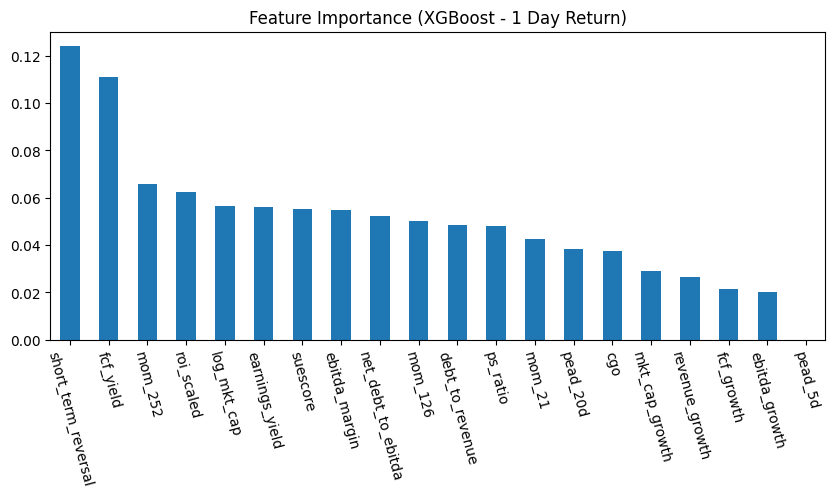

Top 10 Important Features: ['short_term_reversal', 'fcf_yield', 'mom_252', 'roi_scaled', 'log_mkt_cap', 'earnings_yield', 'suescore', 'ebitda_margin', 'net_debt_to_ebitda', 'mom_126']


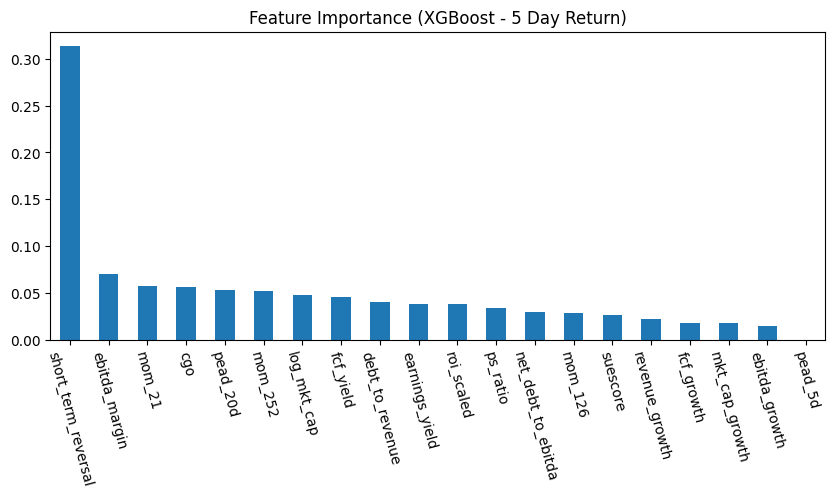

Top 10 Important Features: ['short_term_reversal', 'ebitda_margin', 'mom_21', 'cgo', 'pead_20d', 'mom_252', 'log_mkt_cap', 'fcf_yield', 'debt_to_revenue', 'earnings_yield']


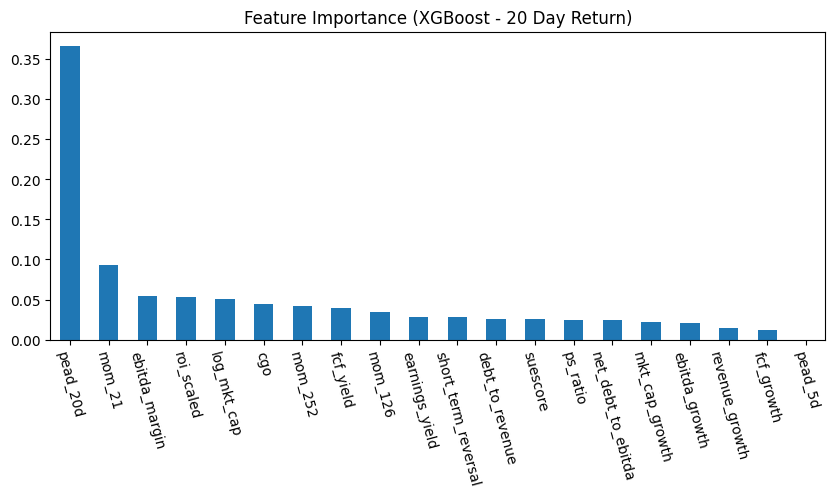

Top 10 Important Features: ['pead_20d', 'mom_21', 'ebitda_margin', 'roi_scaled', 'log_mkt_cap', 'cgo', 'mom_252', 'fcf_yield', 'mom_126', 'earnings_yield']


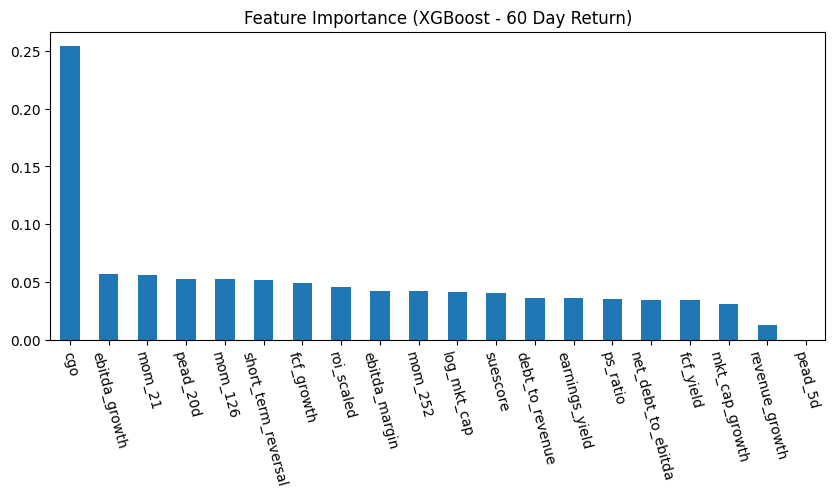

Top 10 Important Features: ['cgo', 'ebitda_growth', 'mom_21', 'pead_20d', 'mom_126', 'short_term_reversal', 'fcf_growth', 'roi_scaled', 'ebitda_margin', 'mom_252']


In [29]:
prediction_target_windows = [1, 5, 20, 60]
feature_importance_dict = {}

ml_data = final_df.copy()

for w in prediction_target_windows:
    prediction_target_window = w

    ml_data['target_return'] = ml_data.groupby('ticker')['adj_close'].pct_change(prediction_target_window).shift(-prediction_target_window)

    ml_data.dropna(subset=['target_return'], inplace=True)

    ml_data = ml_data.dropna(subset=features + ['target_return'])

    X = ml_data[features]
    y = ml_data['target_return']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)

## SC model

In [30]:
final_df.columns

Index(['ticker', 'date', 'adj_close', 'oftic', 'measure', 'fiscalp', 'pyear',
       'pmon', 'usfirm', 'anndats', 'actual', 'surpmean', 'surpstdev',
       'suescore', 'year', 'per_end_date', 'per_type', 'tot_revnu',
       'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt', 'net_lterm_debt',
       'net_curr_debt', 'tot_debt_tot_equity', 'ret_invst',
       'free_cash_flow_per_share', 'ebitda', 'shares_out', 'mkt_val',
       'valid_from', 'adj_open', 'adj_volume', 'days_since_announcement',
       'close_after_announcement', 'return_since_announcement', 'ref_price',
       'cgo', 'mom_21', 'mom_126', 'mom_252', 'short_term_reversal', 'pead_5d',
       'pead_20d', 'ps_ratio', 'earnings_yield', 'fcf_yield', 'ebitda_margin',
       'roi_scaled', 'eps_growth', 'net_debt_to_ebitda', 'debt_to_revenue',
       'revenue_growth', 'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap',
       'fcf_growth', 'target_return_1_day', 'lower_quantile_1_day',
       'upper_quantile_1_day', 'cat_target_re

### Regression based

In [61]:
final_df = pd.read_parquet('../data/final_df.parquet')

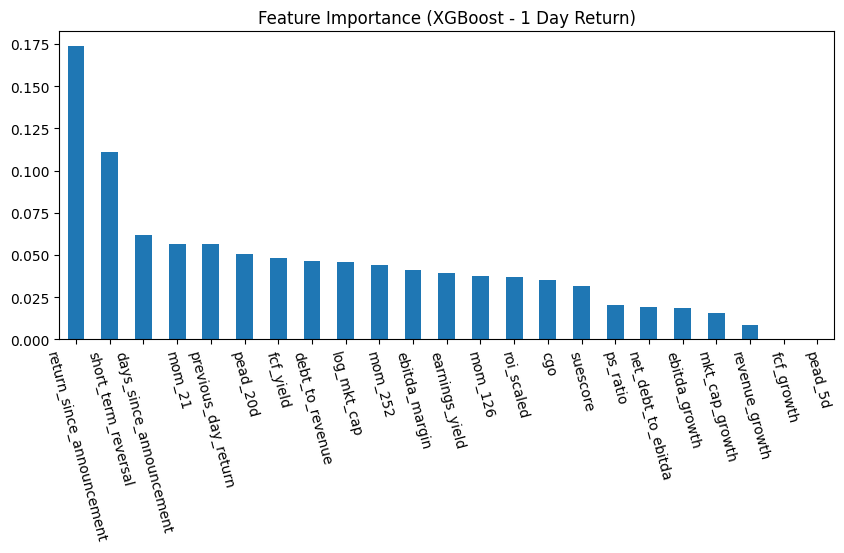

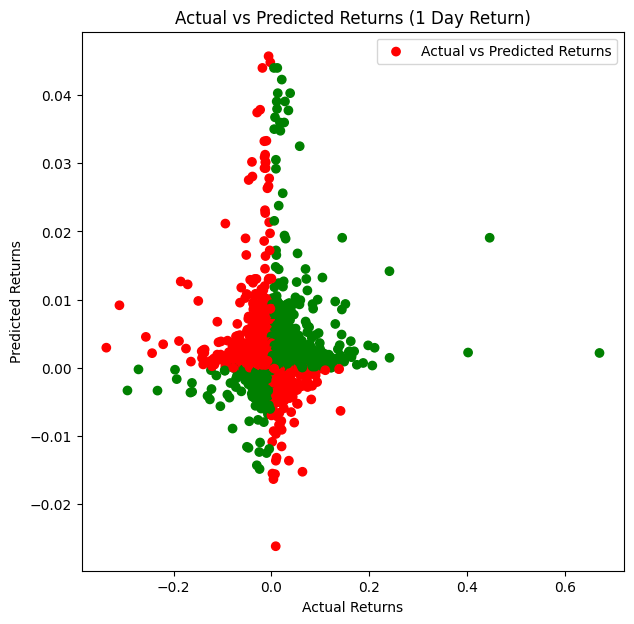

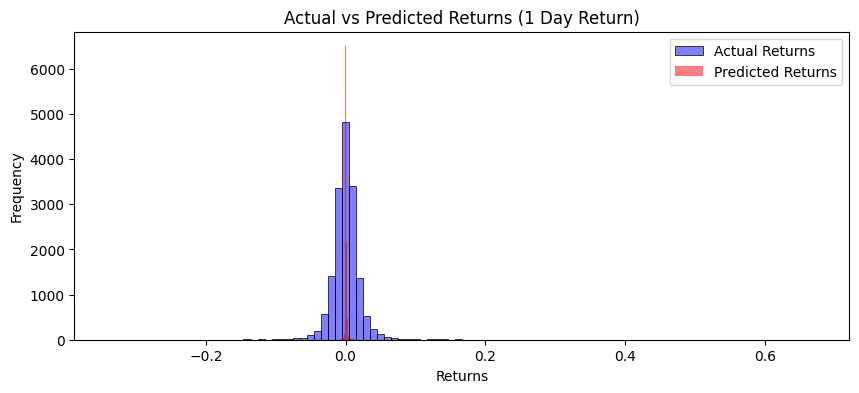

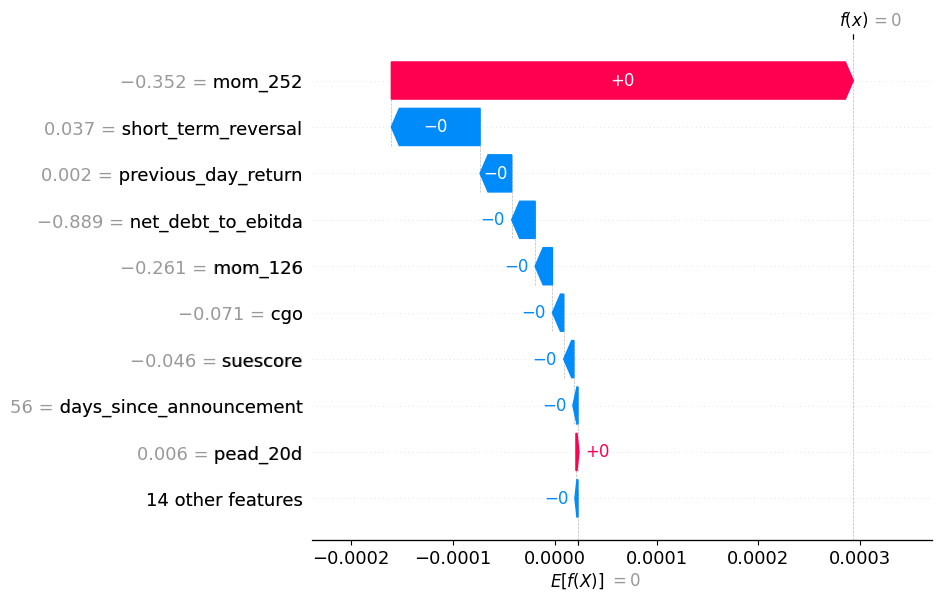

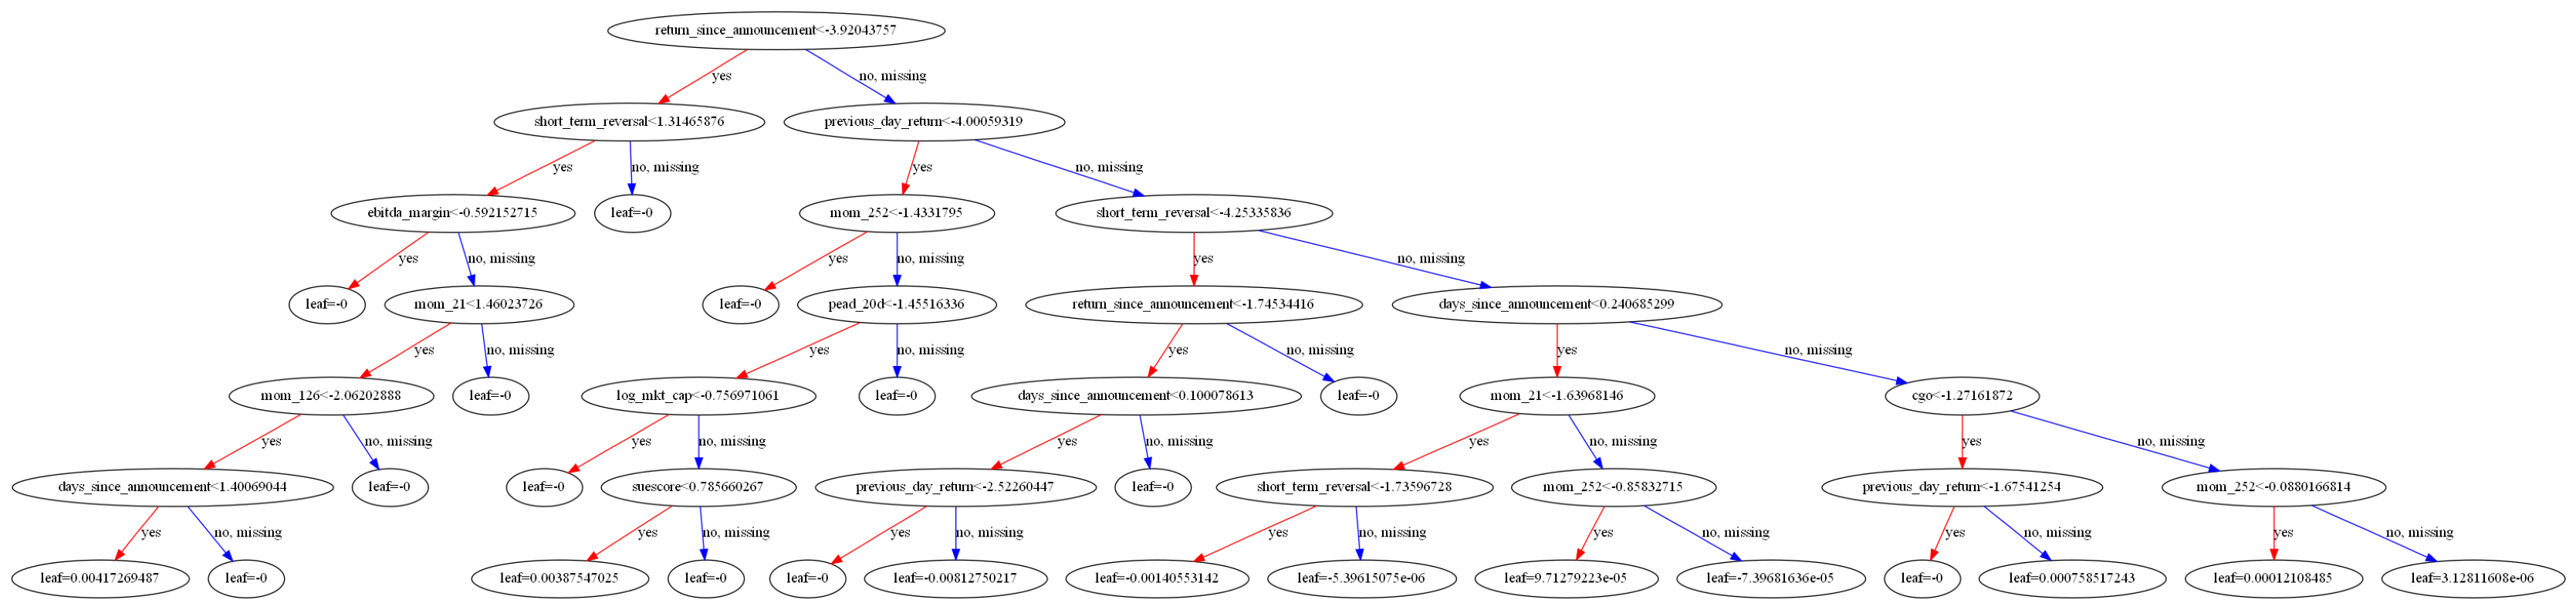

Percentage of Correct Signs: 0.5003335961666768
R2 Score for 1 Day Return: -0.007313666898902671
Mean Absolute Error for 1 Day Return: 0.013785095738012183
Top 10 Important Features: ['return_since_announcement', 'short_term_reversal', 'days_since_announcement', 'mom_21', 'previous_day_return', 'pead_20d', 'fcf_yield', 'debt_to_revenue', 'log_mkt_cap', 'mom_252']


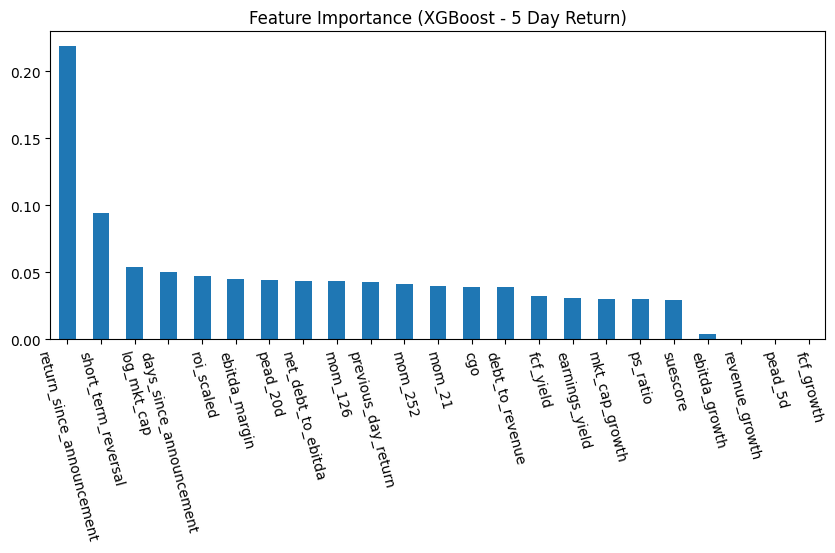

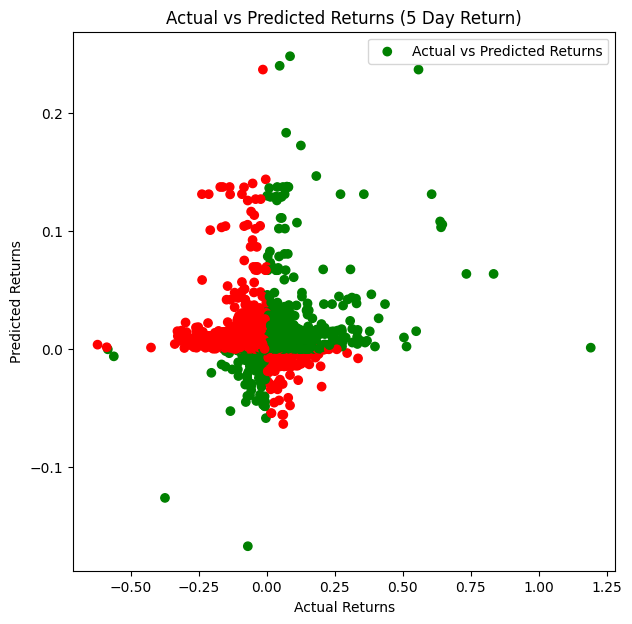

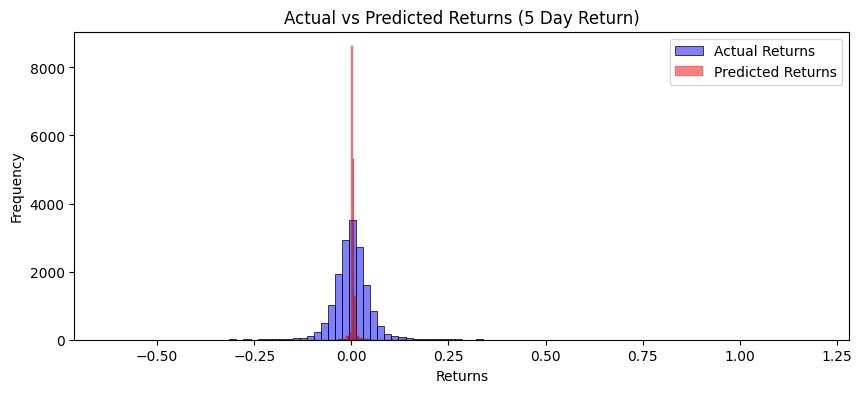

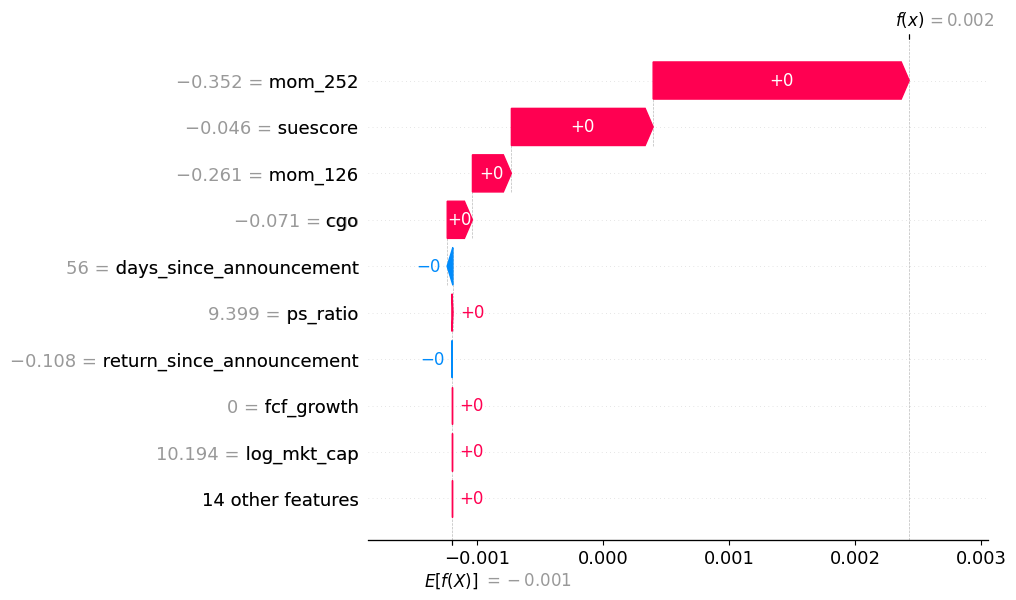

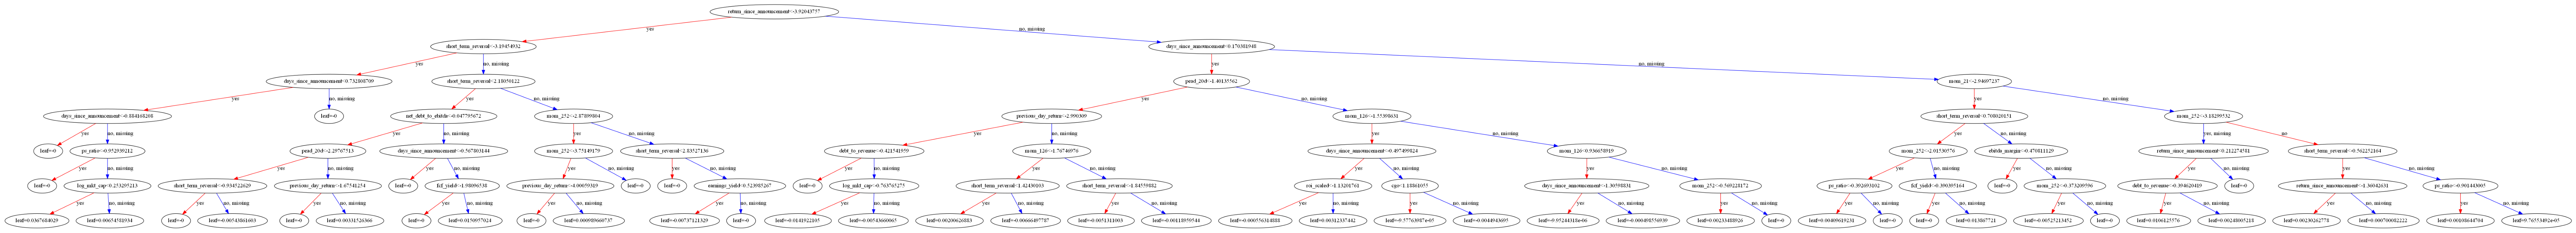

Percentage of Correct Signs: 0.5062170194698854
R2 Score for 5 Day Return: -0.017684043451470233
Mean Absolute Error for 5 Day Return: 0.033891780396581375
Top 10 Important Features: ['return_since_announcement', 'short_term_reversal', 'log_mkt_cap', 'days_since_announcement', 'roi_scaled', 'ebitda_margin', 'pead_20d', 'net_debt_to_ebitda', 'mom_126', 'previous_day_return']


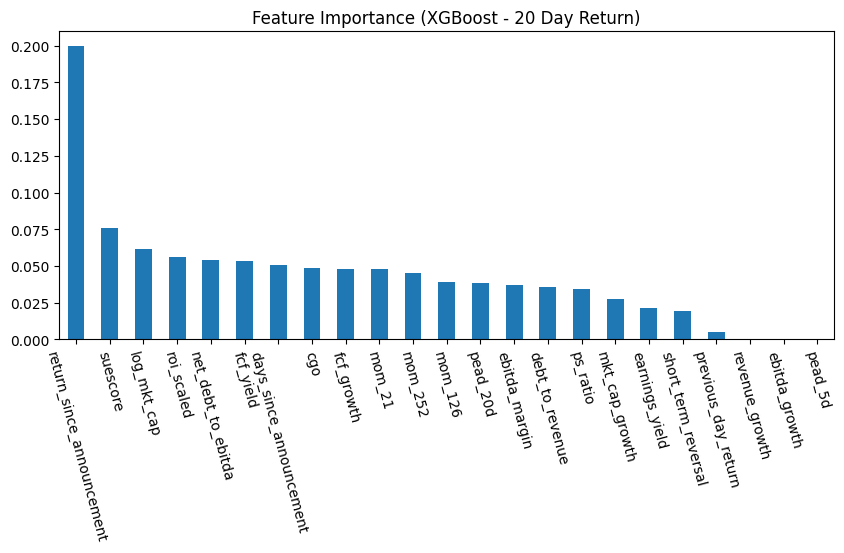

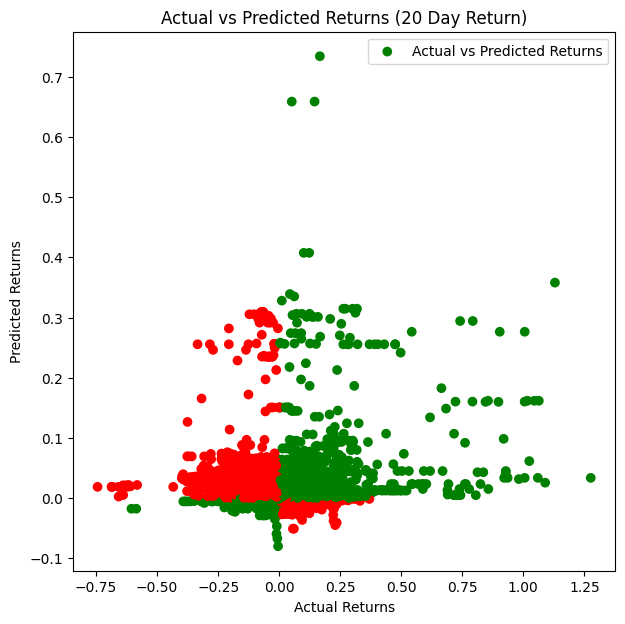

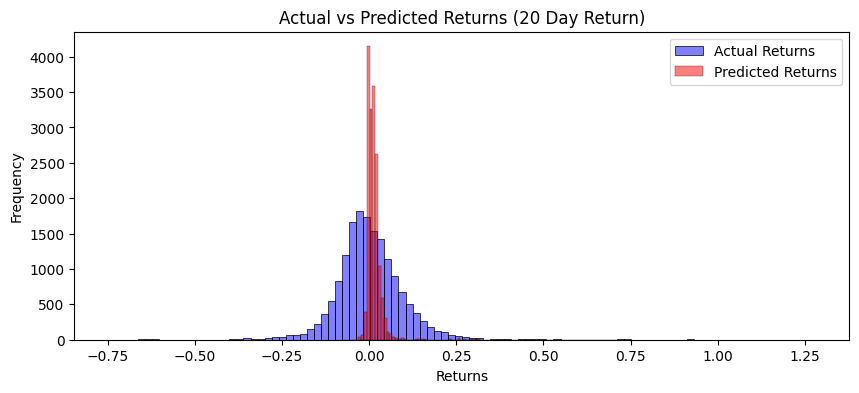

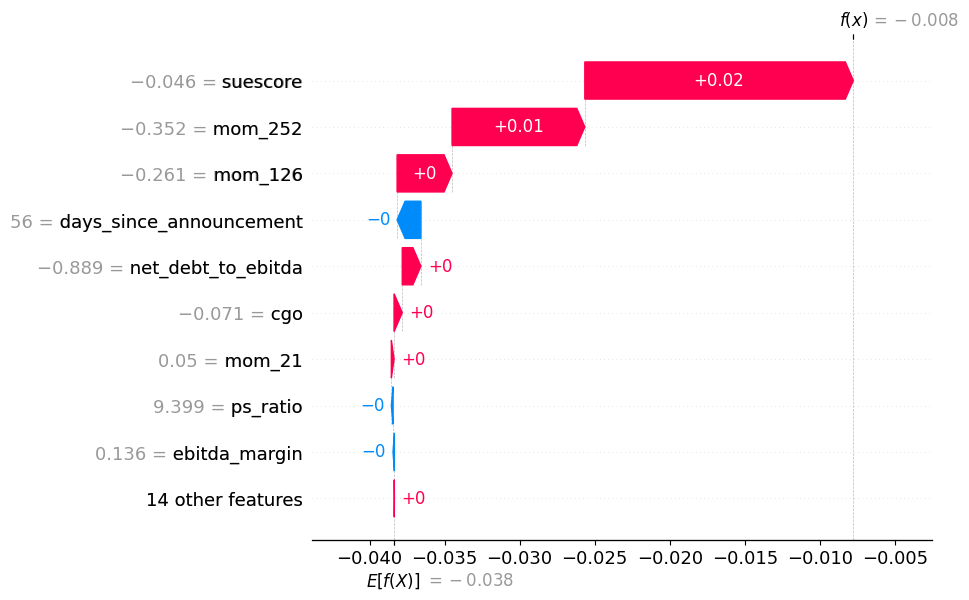

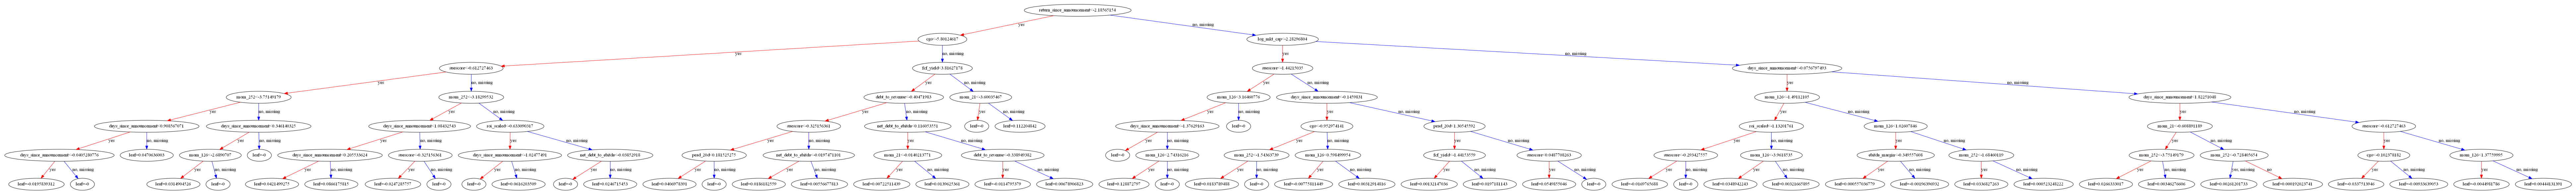

Percentage of Correct Signs: 0.46515436404439864
R2 Score for 20 Day Return: -0.03907011502067781
Mean Absolute Error for 20 Day Return: 0.07446934505094611
Top 10 Important Features: ['return_since_announcement', 'suescore', 'log_mkt_cap', 'roi_scaled', 'net_debt_to_ebitda', 'fcf_yield', 'days_since_announcement', 'cgo', 'fcf_growth', 'mom_21']


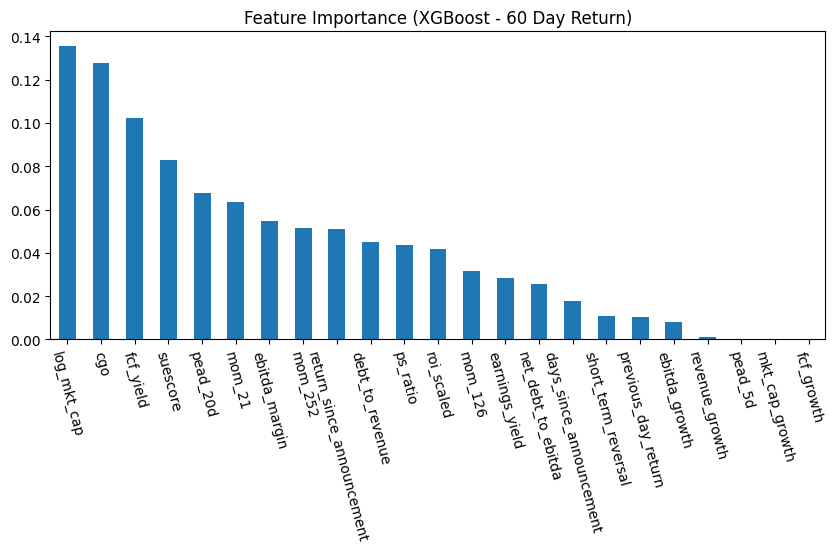

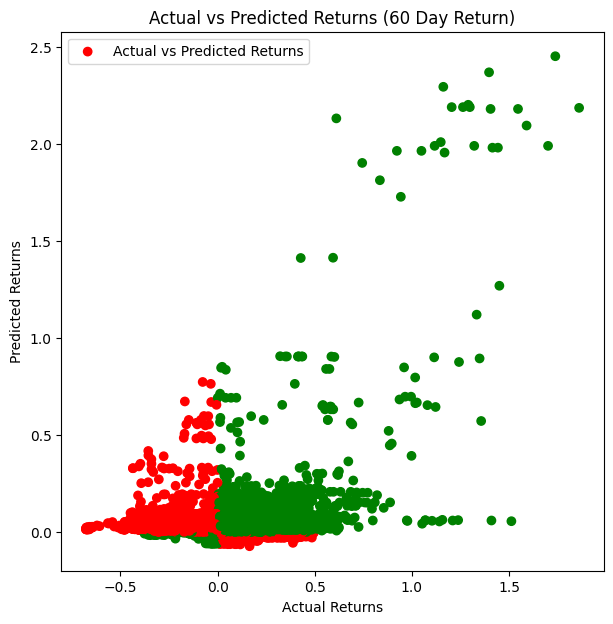

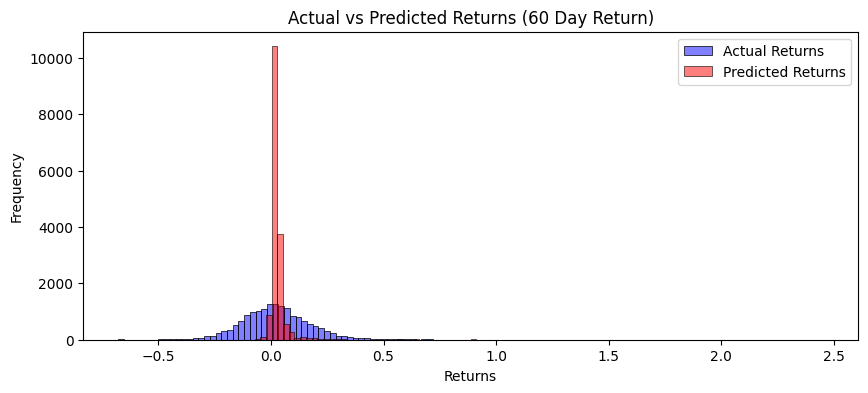

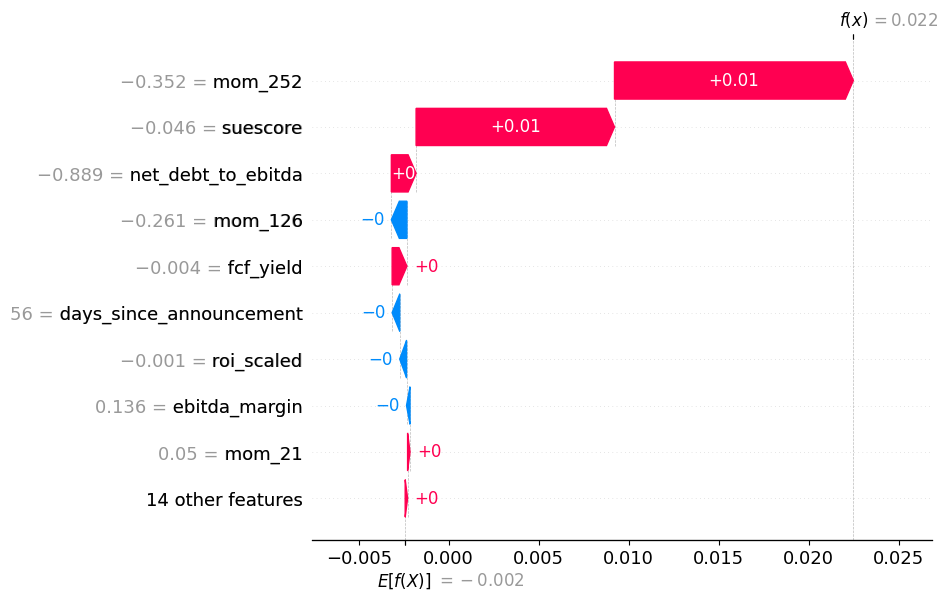

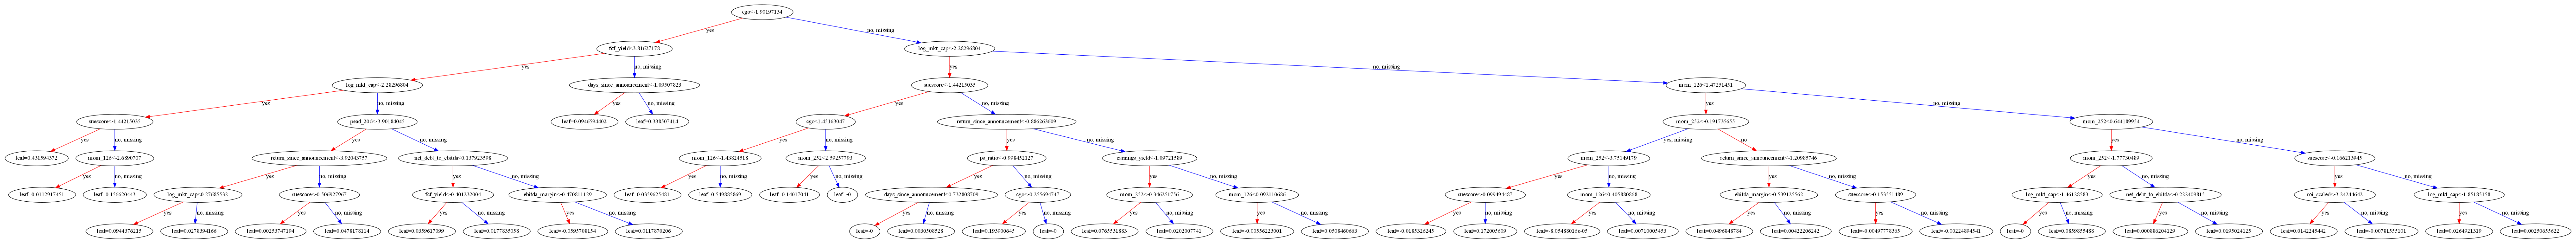

Percentage of Correct Signs: 0.5421240977740037
R2 Score for 60 Day Return: 0.06291576581798342
Mean Absolute Error for 60 Day Return: 0.12325100326229112
Top 10 Important Features: ['log_mkt_cap', 'cgo', 'fcf_yield', 'suescore', 'pead_20d', 'mom_21', 'ebitda_margin', 'mom_252', 'return_since_announcement', 'debt_to_revenue']


In [53]:
from sklearn.metrics import r2_score, mean_absolute_error
import shap

validation_set = final_df.loc[final_df['date']>=pd.to_datetime('2024-01-01')].copy()
in_sample = final_df.loc[final_df['date']<pd.to_datetime('2024-01-01')].copy()
test_size = int(np.floor(len(in_sample) * 0.1))
test_set = in_sample.iloc[-test_size:]
training_set = in_sample.iloc[:-test_size]

req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth', 'days_since_announcement', 'return_since_announcement', 'previous_day_return'
]


for w in prediction_target_windows:   
    
    test_size = int(np.floor(len(in_sample) * 0.1))
    X_train = training_set[features]
    y_train = training_set[f'target_return_{w}_day']
    X_test = test_set[features]
    y_test = test_set[f'target_return_{w}_day']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=25, 
                                 learning_rate=0.1, 
                                 max_depth=6, 
                                 alpha = 2,
                                 random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()
    
    #plot actual vs predicted returns
    y_pred = xgb_model.predict(X_test_scaled)
    plt.figure(figsize=(7, 7)) 
    colors = ['green' if np.sign(actual) == np.sign(pred) else 'red'
          for actual, pred in zip(y_test, y_pred)]

    plt.scatter(y_test, y_pred, label='Actual vs Predicted Returns', c = colors)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.title(f"Actual vs Predicted Returns ({w} Day Return)")
    plt.show()

    # stacked histograms of actual vs predicted returns
    plt.figure(figsize=(10, 4))
    sns.histplot(y_test, color='blue', alpha=0.5, bins=100, label='Actual Returns')
    sns.histplot(y_pred, color='red', alpha=0.5, bins=100, label='Predicted Returns')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f"Actual vs Predicted Returns ({w} Day Return)")
    plt.show()

        # Assuming you have a model and X_train for background data:
    explainer = shap.Explainer(xgb_model, X_train)
    shap_values = explainer(X_test)

    # Choose an instance (e.g., the first instance)
    instance_index = 0
    shap_val_instance = shap_values[instance_index]

    # Round the values to 2 decimal places:
    shap_val_instance.values = np.round(shap_val_instance.values, 6)
    shap_val_instance.base_values = round(shap_val_instance.base_values, 6)
    shap_val_instance.data = np.round(shap_val_instance.data, 6)

    shap.plots.waterfall(shap_val_instance)

        # Assuming features is a list of your actual feature names
    xgb_model.get_booster().feature_names = features
        # Plot the first tree (num_trees=0 for the first tree)
    xgb.plot_tree(xgb_model, num_trees=0)
    plt.rcParams['figure.figsize'] = [100, 10]  # Adjust the size if needed
    plt.show()


    # Print out of sample metrics
    r2 = r2_score(y_test, xgb_model.predict(X_test_scaled))
    mae = mean_absolute_error(y_test, xgb_model.predict(X_test_scaled))
    signs = [1 if np.sign(actual) == np.sign(pred) else 0
        for actual, pred in zip(y_test, y_pred)]
    print("Percentage of Correct Signs:", sum(signs)/len(signs))
    print(f"R2 Score for {w} Day Return: {r2}")
    print(f"Mean Absolute Error for {w} Day Return: {mae}")

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)


### Classification based

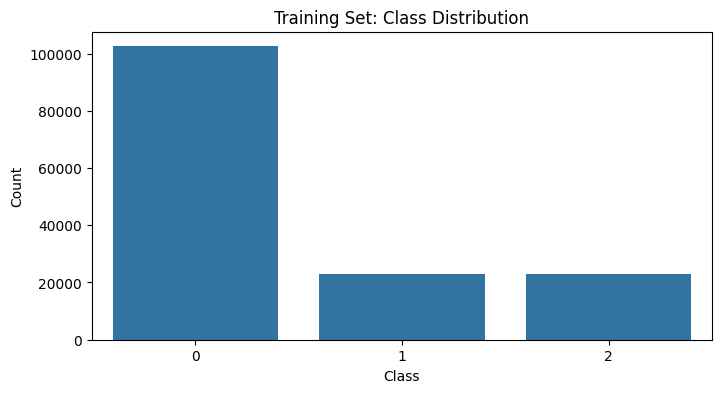

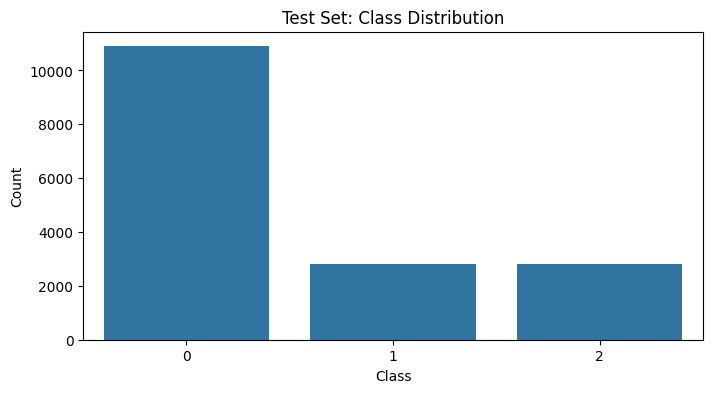

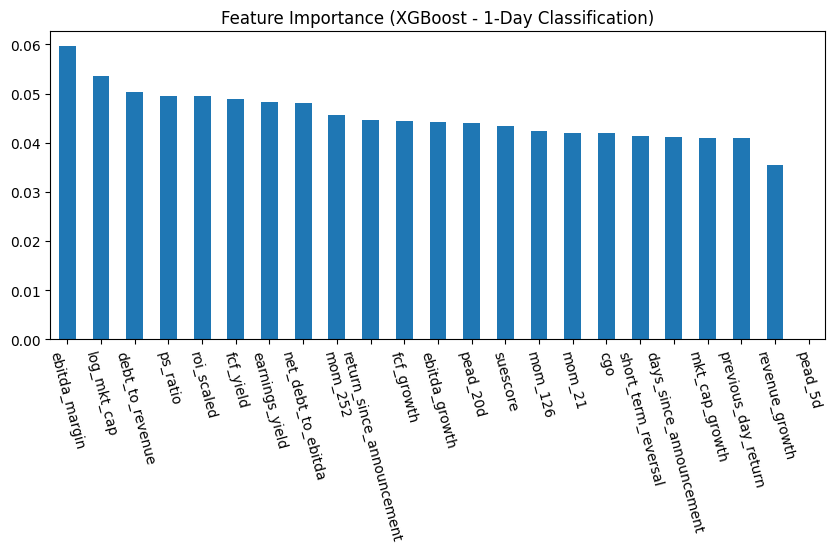

Accuracy (1-Day): 0.659
Confusion Matrix (1-Day):
[[10837    34    22]
 [ 2772    19     8]
 [ 2763    15    17]]


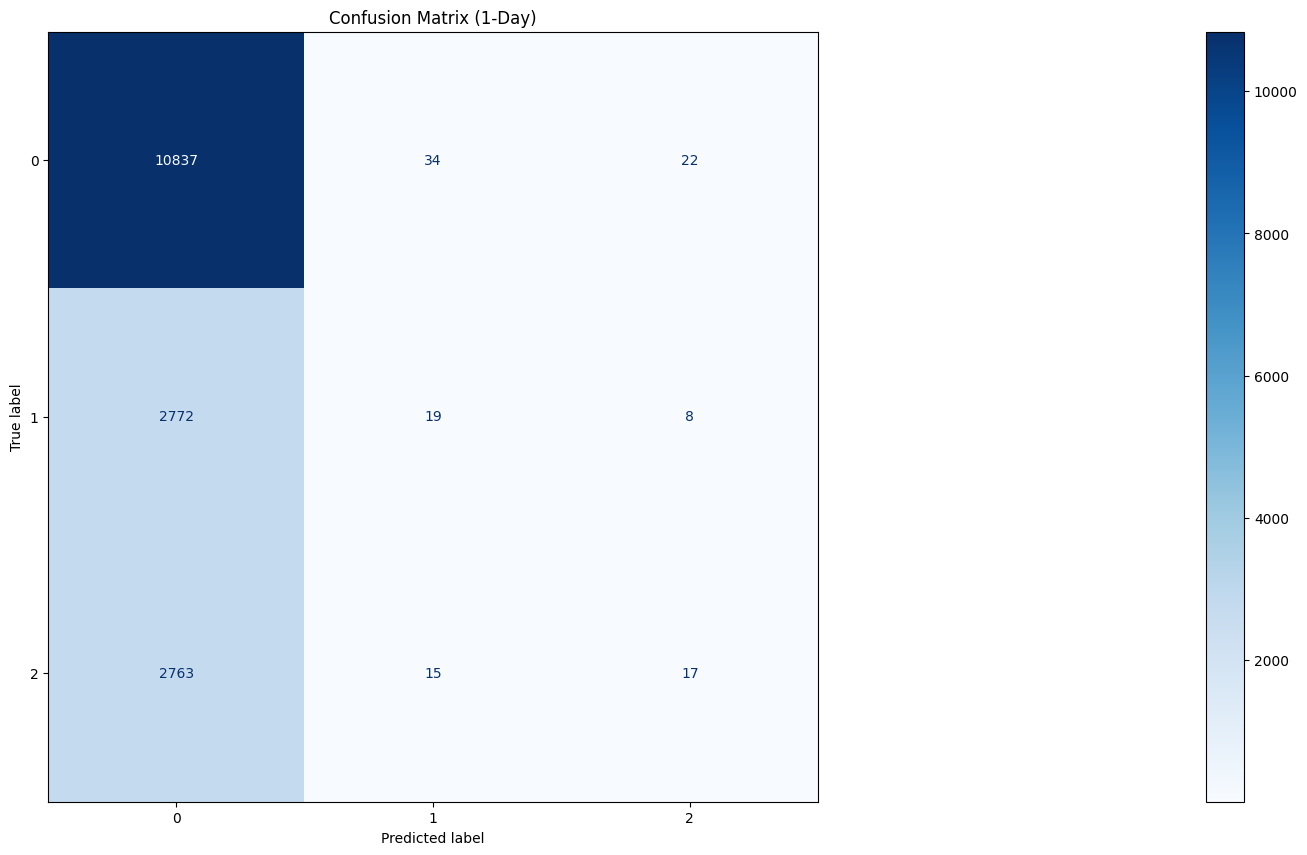

Classification Report (1-Day):
              precision    recall  f1-score   support

           0       0.66      0.99      0.79     10893
           1       0.28      0.01      0.01      2799
           2       0.36      0.01      0.01      2795

    accuracy                           0.66     16487
   macro avg       0.43      0.34      0.27     16487
weighted avg       0.55      0.66      0.53     16487



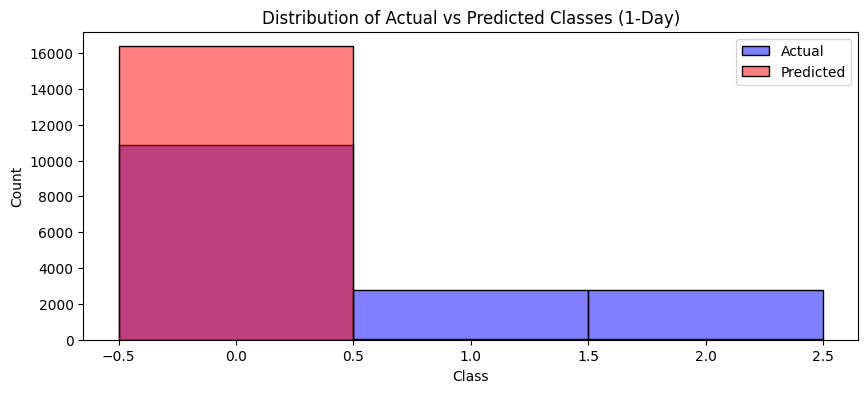

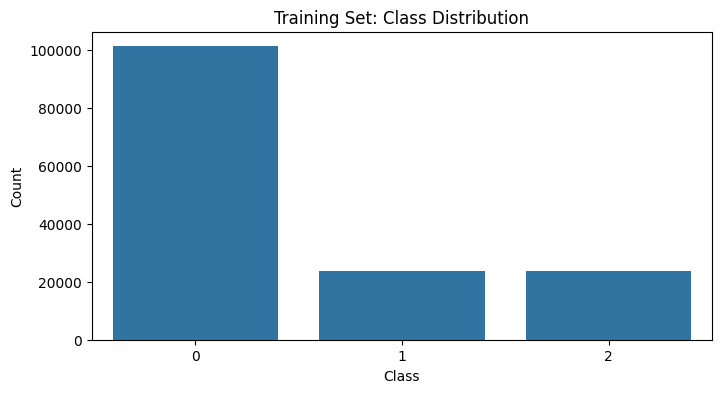

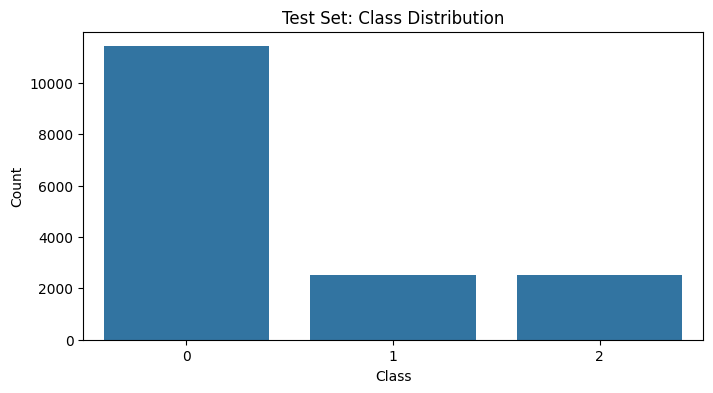

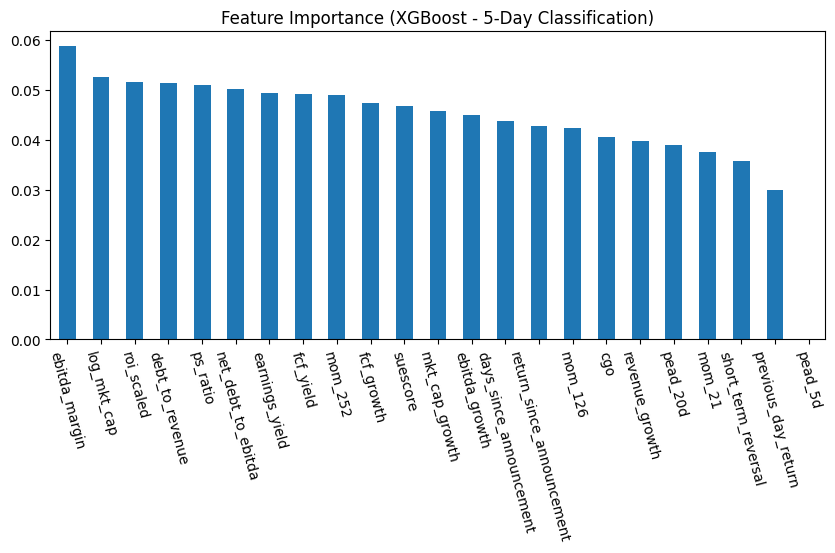

Accuracy (5-Day): 0.688
Confusion Matrix (5-Day):
[[11249    91    78]
 [ 2460    44    34]
 [ 2447    41    43]]


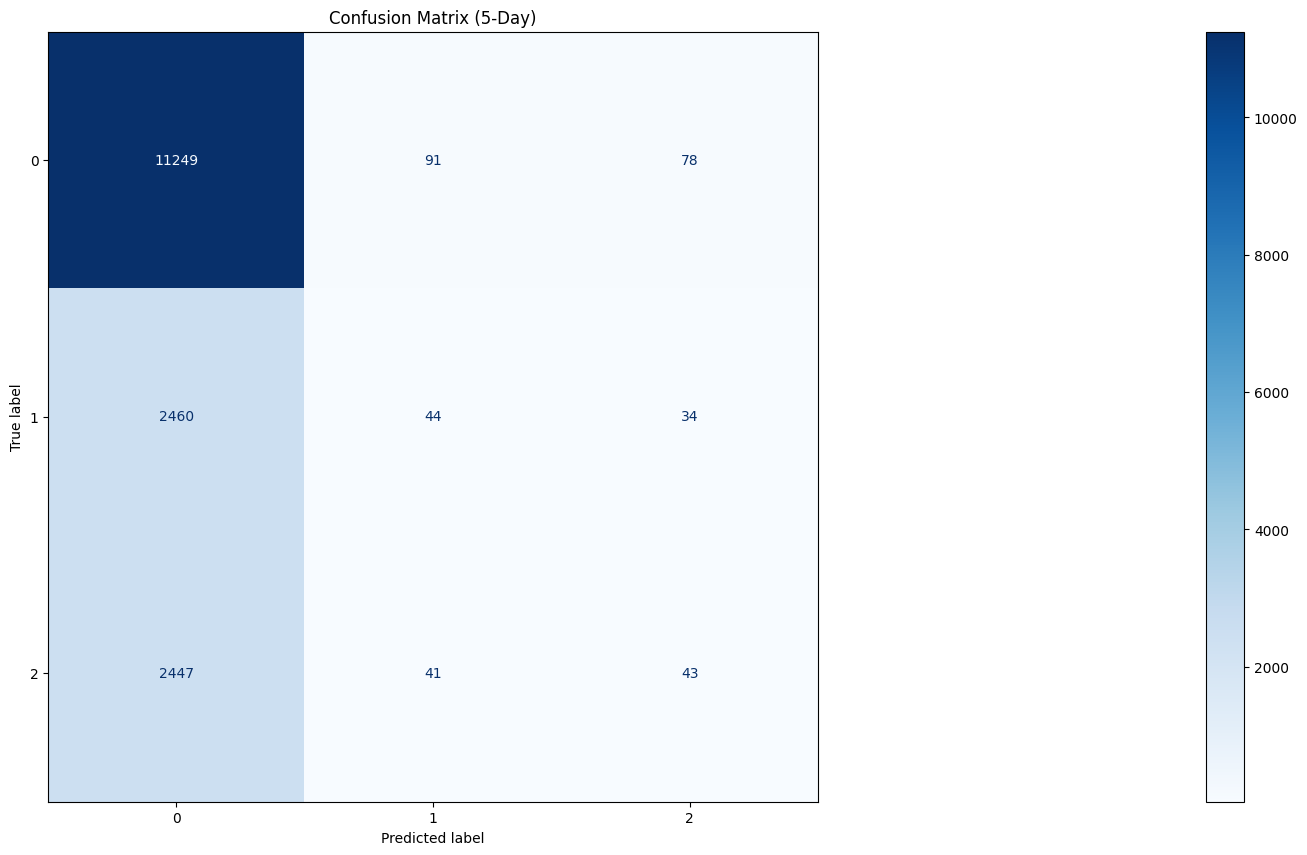

Classification Report (5-Day):
              precision    recall  f1-score   support

           0       0.70      0.99      0.82     11418
           1       0.25      0.02      0.03      2538
           2       0.28      0.02      0.03      2531

    accuracy                           0.69     16487
   macro avg       0.41      0.34      0.29     16487
weighted avg       0.56      0.69      0.57     16487



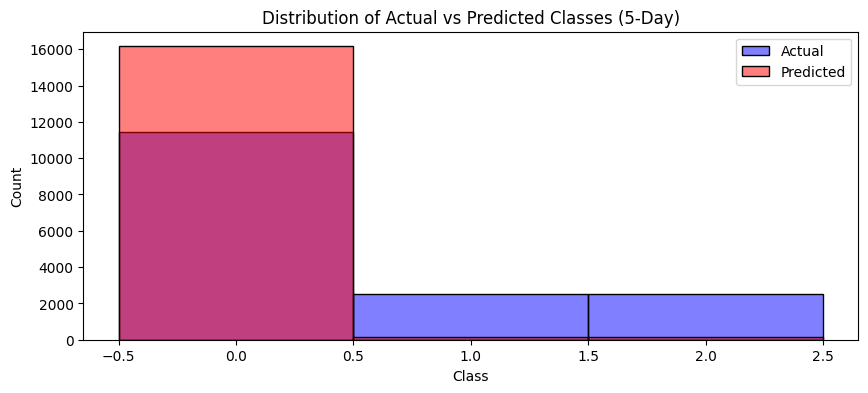

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay
)

# 1) Split your data into training, test, and validation sets
validation_set = final_df.loc[final_df['date'] >= pd.to_datetime('2024-01-01')].copy()
in_sample = final_df.loc[final_df['date'] < pd.to_datetime('2024-01-01')].copy()

test_size = int(np.floor(len(in_sample) * 0.1))
test_set = in_sample.iloc[-test_size:]
training_set = in_sample.iloc[:-test_size]

# 2) Define your columns
req_cols = [
    'ticker',
    'date',
    'adj_close'
]

features = [
    'suescore', 'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth', 
    'days_since_announcement', 'return_since_announcement', 'previous_day_return'
]

prediction_target_windows = [1, 5]  # Example
feature_importance_dict = {}

for w in prediction_target_windows:
    # 3) Prepare X and y for classification
    #    * Instead of 'target_return_{w}_day', we use 'cat_target_return_{w}_day'


    X_train = training_set[features]
    y_train = training_set[f'cat_target_return_{w}_day']  # e.g. -1, 0, 1
    X_test = test_set[features]
    y_test = test_set[f'cat_target_return_{w}_day']

    # 4) Scale your features (optional but often helpful)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    class_counts = y_train.value_counts()
# e.g. class_counts might be: {0: 10000, 1: 6000, 2: 4000}

    # Invert them so smaller classes get higher weights:
    weights = (1.0 / class_counts)
    # e.g. => {0: 0.0001, 1: 0.000166..., 2: 0.00025}

    # Then map each sample in y_train to its class weight:
    class_weight_map = {0: 1, 1: 10, 2: 10}

    sample_weight = y_train.map(class_weight_map)

    # 5) Create and train an XGBClassifier
    #    If you have three classes (-1, 0, 1), use 'multi:softmax' with num_class=3
    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Use 'hist' for faster training
        n_estimators=10,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        objective='multi:softprob',  # multi-class objective
        num_class=3,
        sample_weight=sample_weight  # Pass the sample weights here
    )
    xgb_model.fit(X_train_scaled, y_train)

    # 6) Feature importance (from XGBClassifier)
    feature_importance = pd.Series(
        xgb_model.feature_importances_,
        index=features
    ).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75)
    plt.title(f"Feature Importance (XGBoost - {w}-Day Classification)")
    plt.show()

    # 7) Predictions and classification metrics
    y_pred = xgb_model.predict(X_test_scaled)

    # -- Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({w}-Day): {accuracy:.3f}")

    # -- Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix ({w}-Day):\n{cm}")

    # -- Display confusion matrix nicely
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=xgb_model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix ({w}-Day)")
    plt.show()

    # -- Classification Report
    report = classification_report(y_test, y_pred, zero_division=0)
    print(f"Classification Report ({w}-Day):\n{report}")

    # 8) Plot distribution of actual vs predicted classes
    plt.figure(figsize=(10, 4))
    sns.histplot(y_test, color='blue', alpha=0.5, bins=3, label='Actual', discrete=True)
    sns.histplot(y_pred, color='red', alpha=0.5, bins=3, label='Predicted', discrete=True)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend()
    plt.title(f"Distribution of Actual vs Predicted Classes ({w}-Day)")
    plt.show()

    # # 9) SHAP on a classifier
    # #    You can still generate SHAP values, but be aware that for multi-class,
    # #    SHAP returns a list/array of values per class. We'll just show class 0
    # #    or the sum, depending on your preference.
    # explainer = shap.Explainer(xgb_model, X_train_scaled)
    # shap_values = explainer(X_test_scaled)  # This will be an array with dimension [n_samples, num_class, features]

    # # If you want the SHAP values for one class (e.g. class 0) or the "sum" to interpret overall effect:
    # # shap_values_for_class0 = shap_values[:, 0, :]  # shape = (n_samples, n_features)
    # # But for a quick single sample waterfall (for class 0), do:
    # sample_idx = 0
    # shap_vals_sample = shap_values[sample_idx, 0, :]  # 0 -> first class 
    # # If your classes are [-1, 0, 1], pick the correct index or interpret carefully.

    # # Convert to a format suitable for the waterfall plot:
    # # The shap.plots.waterfall expects the "explanation" object, so a quick hack:
    # single_expl = shap.Explanation(
    #     values=shap_vals_sample.values,  # or shap_vals_sample
    #     base_values=shap_vals_sample.base_values, 
    #     data=X_test_scaled[sample_idx]
    # )

    # # Waterfall plot for the chosen sample and chosen class
    # shap.plots.waterfall(single_expl)

    # 10) (Optional) Tree Plot
    # xgb_model.get_booster().feature_names = features
    # xgb.plot_tree(xgb_model, num_trees=0)
    # plt.rcParams['figure.figsize'] = [100, 10]  # adjust size
    # plt.show()


### RF model

Accuracy: 0.582
Confusion Matrix:
[[8793 1141  959]
 [2027  418  354]
 [2030  384  381]]


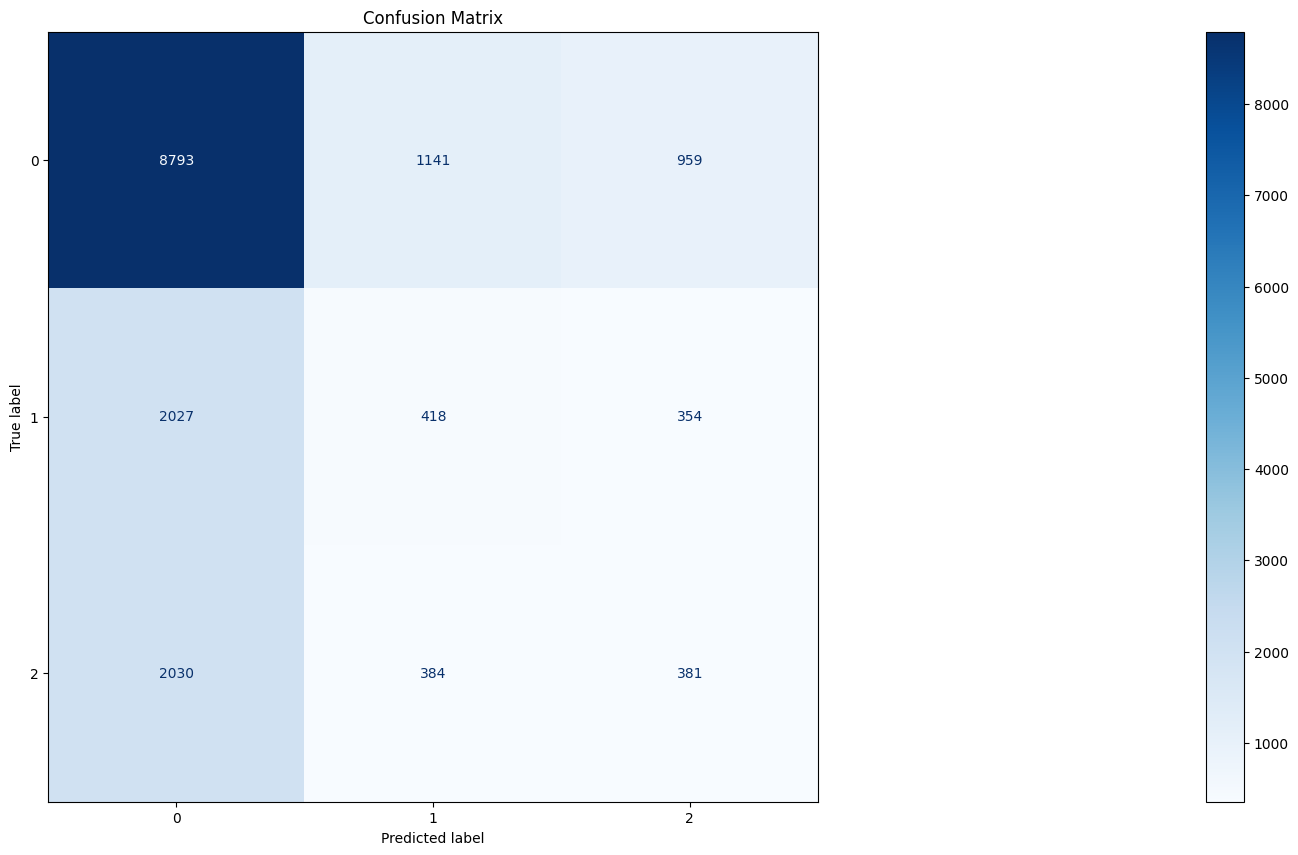

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74     10893
           1       0.22      0.15      0.18      2799
           2       0.22      0.14      0.17      2795

    accuracy                           0.58     16487
   macro avg       0.37      0.36      0.36     16487
weighted avg       0.53      0.58      0.55     16487



In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# 1) Split your data into training, test, and validation sets
validation_set = final_df.loc[final_df['date'] >= pd.to_datetime('2024-01-01')].copy()
in_sample = final_df.loc[final_df['date'] < pd.to_datetime('2024-01-01')].copy()
test_size = int(np.floor(len(in_sample) * 0.1))
test_set = in_sample.iloc[-test_size:]
training_set = in_sample.iloc[:-test_size]

# 2) Visualize class distributions in the training set and test set
target_col = "cat_target_return_1_day"  # Change this if needed


# 3) Define your features and target for the 5-day classification
features = [
    'suescore', 'cgo', 
    'mom_21', 'mom_126', 'mom_252', 'short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio', 'earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth', 
    'days_since_announcement', 'return_since_announcement', 'previous_day_return'
]

X_train = training_set[features]
y_train = training_set[target_col]
X_test = test_set[features]
y_test = test_set[target_col]

# 4) Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5) Define sample weights based on class to boost underrepresented classes
# For example, if you want to weight classes 1 and 2 higher:
class_weight_map = {0: 1, 1: 4, 2: 4}
sample_weight = y_train.map(class_weight_map).values  # Create an array of weights

# 6) Create DMatrix objects for XGBoost training and testing
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=sample_weight)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# 7) Set up the parameter dictionary for Random Forest using the XGBoost native API.
#    Note: We use num_parallel_tree to set the number of trees, and num_boost_round=1 so that XGBoost trains
#    a single random forest instead of boosting multiple forests.
params = {
    "colsample_bynode": 0.8,         # Randomly sample columns for each split
    "learning_rate": 1,              # Must be set to 1 for random forest training
    "max_depth": 4,
    "num_parallel_tree": 100,        # Number of trees in the forest
    "objective": "multi:softprob",   # Multi-class classification with probabilities
    "num_class": 3,                  # Number of classes
    "subsample": 0.8,                # Randomly sample rows (cases)
    "tree_method": "gpu_hist",       # Use GPU acceleration; for CPU use "hist"
    "gpu_id": 0,
    "seed": 42
}

num_boost_round = 1  # Train a single random forest

# 8) Train the model
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# 9) Make predictions on the test set
y_pred_prob = bst.predict(dtest)  # Returns probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)

# 10) Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))


## Daily rebalancing

In [23]:
final_df['next_day_open'] = final_df.groupby('ticker')['adj_open'].shift(-1)
final_df[final_df['ticker']=='AAPL'].tail(20)

ticker       date   adj_close oftic measure fiscalp   pyear  pmon  \
187448   AAPL 2024-09-09  220.666932  AAPL     EPS     QTR  2024.0   6.0   
187641   AAPL 2024-09-10  219.867812  AAPL     EPS     QTR  2024.0   6.0   
187729   AAPL 2024-09-11  222.415006  AAPL     EPS     QTR  2024.0   6.0   
187843   AAPL 2024-09-12  222.524885  AAPL     EPS     QTR  2024.0   6.0   
187969   AAPL 2024-09-13  222.255182  AAPL     EPS     QTR  2024.0   6.0   
188081   AAPL 2024-09-16  216.081982  AAPL     EPS     QTR  2024.0   6.0   
188301   AAPL 2024-09-17  216.551465  AAPL     EPS     QTR  2024.0   6.0   
188380   AAPL 2024-09-18  220.447174  AAPL     EPS     QTR  2024.0   6.0   
188506   AAPL 2024-09-19  228.618173  AAPL     EPS     QTR  2024.0   6.0   
188689   AAPL 2024-09-20  227.948911  AAPL     EPS     QTR  2024.0   6.0   
188837   AAPL 2024-09-23  226.220814  AAPL     EPS     QTR  2024.0   6.0   
188906   AAPL 2024-09-24  227.119824  AAPL     EPS     QTR  2024.0   6.0   
189013   AAPL 2024-09-25  226.120924  AAPL     EPS     QTR  2024.0   6.0   
189229   AAPL 2024-09-26  227.269659  AAPL     EPS     QTR  2024.0   6.0   
189254   AAPL 2024-09-27  227.539362  AAPL     EPS     QTR  2024.0   6.0   
189465   AAPL 2024-09-30  232.743629  AAPL     EPS     QTR  2024.0   6.0   
189518   AAPL 2024-10-01  225.961100  AAPL     EPS     QTR  2024.0   6.0   
189687   AAPL 2024-10-02  226.530473  AAPL     EPS     QTR  2024.0   6.0   
189800   AAPL 2024-10-03  225.421694  AAPL     EPS     QTR  2024.0   6.0   
189920   AAPL 2024-10-04  226.550451  AAPL     EPS     QTR  2024.0   6.0   

        usfirm    anndats  actual  surpmean  surpstdev  suescore    year  \
187448     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187641     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187729     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187843     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
187969     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188081     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188301     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188380     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188506     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188689     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188837     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
188906     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189013     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189229     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189254     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189465     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189518     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189687     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189800     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   
189920     1.0 2024-08-01     1.4   1.34627    0.03816   1.40815  2024.0   

       per_end_date per_type  tot_revnu  eps_diluted_net  basic_net_eps  \
187448   2021-06-30        Q    81434.0              1.3           1.31   
187641   2021-06-30        Q    81434.0              1.3           1.31   
187729   2021-06-30        Q    81434.0              1.3           1.31   
187843   2021-06-30        Q    81434.0              1.3           1.31   
187969   2021-06-30        Q    81434.0              1.3           1.31   
188081   2021-06-30        Q    81434.0              1.3           1.31   
188301   2021-06-30        Q    81434.0              1.3           1.31   
188380   2021-06-30        Q    81434.0              1.3           1.31   
188506   2021-06-30        Q    81434.0              1.3           1.31   
188689   2021-06-30        Q    81434.0              1.3       

## Data Analysis

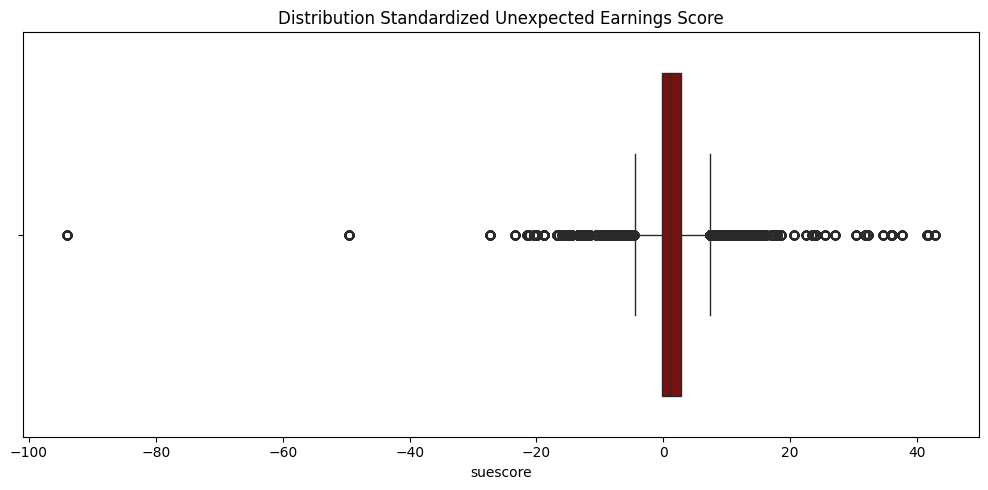

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=final_df['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

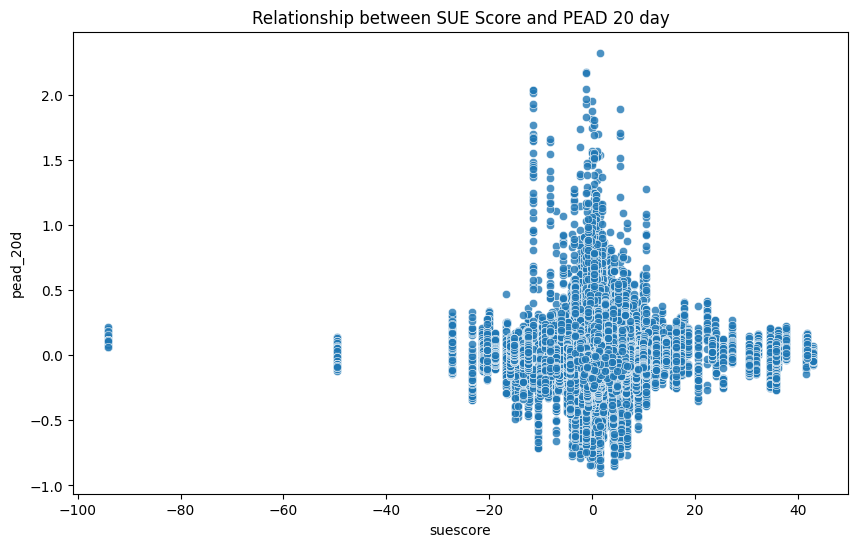

In [123]:
plt.figure(figsize=(10, 6))

plot_df = final_df.copy()

sns.scatterplot(
    x='suescore', 
    y='pead_20d', 
    data=plot_df, 
    palette='tab10',
    alpha=0.8  
)

plt.xlabel('suescore')
plt.ylabel('pead_20d')
plt.title('Relationship between SUE Score and PEAD 20 day')

plt.show()

sue_quantile
Low     0.004263
Q2      0.009906
Q3      0.015442
Q4      0.018446
High    0.021646
Name: pead_20d, dtype: float64


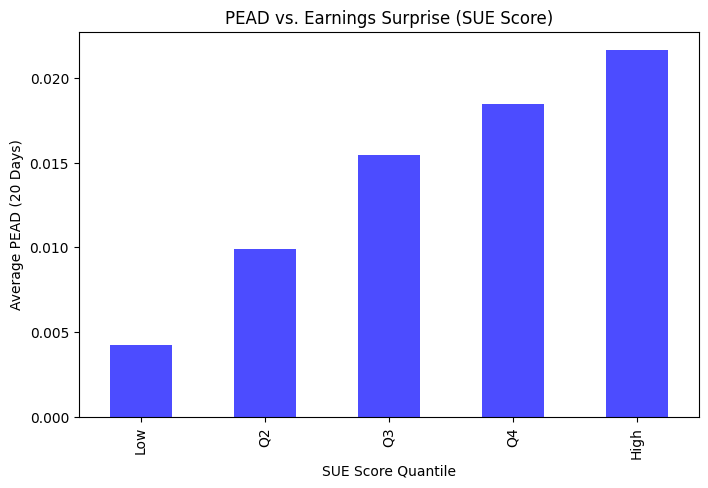

In [124]:
final_df['sue_quantile'] = pd.qcut(final_df['suescore'], q=5, labels=['Low', 'Q2', 'Q3', 'Q4', 'High'])

sue_pead_summary = final_df.groupby('sue_quantile')['pead_20d'].mean()
print(sue_pead_summary)

plt.figure(figsize=(8,5))
sue_pead_summary.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("SUE Score Quantile")
plt.ylabel("Average PEAD (20 Days)")
plt.title("PEAD vs. Earnings Surprise (SUE Score)")
plt.show()

## Strategy Implementation

## Backtesting

## Performance Analysis

## References